# LMSYS - Detailed EDA
**Thanks to the great work of Abao Jiang (https://www.kaggle.com/abaojiang), this notebook is inspired from his work（https://www.kaggle.com/code/abaojiang/lmsys-detailed-eda) and translated into Japanese.**
**このノートブックは、Abao Jiang氏によるDetailed EDA(https://www.kaggle.com/code/abaojiang/lmsys-detailed-eda)の日本語訳版になります。**

元著者のEDAがかなり緻密で詳細なため、ぜひ内容理解にお役立てください。
日本語の内容に多少の不備がございますのでコメントなどでお知らせください。

## 当コンペについて
LLMからのスムーズな返答、特にニーズに見合ったものは好まれる傾向にある。同じプロンプトであっても、使用しているAIによってその返答は多岐にわたる。したがって、ユーザーの好みを把握す釣ることがLLMの精度を高めることになる。当コンペでは、2つの異なるLLMからユーザーの入力したプロンプトに返答し、判断者（ユーザー）の好みによってプロンプト - 回答の良いものを推測する。

### 注意
公式発表[3.1](https://arxiv.org/pdf/2403.04132)に書かれているように、1チャットにつき1つ以上のプロンプト/回答が記載されている可能性もある。ユーザーが最初のターンで優劣をつけられなかった場合、勝敗を決めるまでチャットし続けられる。


## このノートブックについて
このカーネルでは、データ理解の為にまずEDAを行う。その後基本的なモデル構築を行い、提出できるようなベースラインモデルを作成まで行う。

<a id="toc"></a>
## 目次
* [1. データの外観](#data_appearance)
    * *[クイックサマリー](#quick_sum)*
    * *[1行目のデータを参照する](#one_chat)*
* [2. 特徴量とターゲット探索](#feat_and_tgt)
    * *[LLMモデルの組み合わせ - (model_a, model_b)](#model_pair)*
    * *[レポート](#btl)*
    * *[プロンプトと回答について](#prompt_and_res)*
    * *[回答が生成されていないことの影響](#miss_res)*
    * *[長さについて - ターン（入力回数）と冗長性](#len)*
* [3. 勝敗基準ラインの確認](#naive)
    * *[全てが1/3と仮定](#1_3)*
    * *[全体の平均値と一致すると仮定](#mean)*
    * *[LLM毎に平均を取って勝率を予測](#llm_mean)*
    * *[バケットごとの平均値で推論](#len_diff)*
* [4. 機械学習を用いたベースライン](#ml)
    * *[特徴量エンジニアリング](#fe)*
    * *[特徴量が1つのみの決定木](#dt)*
    * *[より多くの特徴量](#more_feat)*
* その他分析結果は随時更新中...
* [参考](#ref)<a id="toc"></a>

## ライブラリなどのインストール

In [51]:
import re
import time
import warnings
from pathlib import Path
from tqdm import tqdm
from typing import Any, Dict, List, Optional
from IPython.display import display, HTML

import pandas as pd 
import numpy as np
import scipy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator
from sklearn.model_selection import BaseCrossValidator, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.tree import plot_tree
from matplotlib import patches
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec

# 設定項目
warnings.simplefilter("ignore")
sns.set_style("darkgrid")
pd.options.display.max_rows = None
pd.options.display.max_columns = None
colors = sns.color_palette("pastel")

## PATHとユーティリティの定義

In [52]:
DATA_PATH = Path("/kaggle/input/lmsys-chatbot-arena")

TARGETS = ["winner_model_a", "winner_model_b", "winner_tie"]

## データのロードを行う
最初に `train.csv`, `test.csv` と`sample_submission.csv`を含むデータのロードを行っておく。<br>

In [53]:
train = pd.read_csv(DATA_PATH / "train.csv")
test = pd.read_csv(DATA_PATH / "test.csv")
sub = pd.read_csv(DATA_PATH / "sample_submission.csv")

<a id="data_appearance"></a>
## 1. データの外観
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻る</span>**](#toc)

データのロードが完了したら、訓練データとテストデータにある情報に目を通してみる。以下は`train.csv`に含まれるデータの詳細。

* `id` - 各列のユニークなID。
* `model_[a/b]` - モデルAとBの分類。訓練データには含まれているが、テストデータには含まれていない。
* `prompt` - インプットに対して与えられているプロンプト（A/Bどちらのモデルにも与えられている）。
* `response_[a/b]` - 与えられたプロンプトに対してモデルA/Bから返ってきた回答。
* `winner_model_[a/b/tie]` - ユーザーが下した勝者について、バイナリ列で表現。正解情報となる列。

<a id="quick_sum"></a>
### *クイックサマリー*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻る</span>**](#toc)
1. 57477行の訓練データと3行のテストデータがある。
    * **注意:** テストデータは評価の際に**フルサイズのテストデータ**（~25,000行）に置き換えられます。
2. 列`id` には重複行はない。
3. モデルの種類についてはテストデータセットに含まれていない。
    * **問題提起:** まず利用されたLLMモデルの特定を行い、その情報をユーザーの判断した好みとして推論することはできないだろうか？
4. 列に含まれた文字データ `prompt`, `response_a`　と `response_a` はリスト形式。各チャット回答内容については、一つ以上の**プロンプトと回答のペア**を含めることができる。
5. 14行の重複した行が含まれている。（7グループ）

In [54]:
print(f"データの形状 | 訓練データ {train.shape} | テストデータ {test.shape}")
print(f"-" * 50)
print(f">>> 訓練データの最初の3行 <<<")
display(train.head(3))
print(f"-" * 50)
print(f">>> テストデータの最初の3行 <<<")
display(test.head(3))
assert train["id"].nunique() == len(train)

データの形状 | 訓練データ (57477, 9) | テストデータ (3, 4)
--------------------------------------------------
>>> 訓練データの最初の3行 <<<


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1


--------------------------------------------------
>>> テストデータの最初の3行 <<<


,id,prompt,response_a,response_b
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran..."
1,211333,"[""You are a mediator in a heated political deb...","[""Thank you for sharing the details of the sit...","[""Mr Reddy and Ms Blue both have valid points ..."
2,1233961,"[""How to initialize the classification head wh...","[""When you want to initialize the classificati...","[""To initialize the classification head when p..."


 テストデータには、予測するべきもの（どちらが勝ったか）は当然なく、モデル名もない。

分析に不要と判断したため、`id`列をドロップ。テストデータでは提出を踏まえ`id`列は残しておく。

In [55]:
train = train.drop("id", axis=1)
print(f"'id'の列を削除後、訓練データのDataFrameは{train.shape}.となる")
print(f"-" * 50)
print(f">>> The First 3 Training Rows <<<")
train.head(3)

'id'の列を削除後、訓練データのDataFrameは(57477, 8).となる
--------------------------------------------------
>>> The First 3 Training Rows <<<


,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1


14行、7つのグループで重複が見られた。ここでは、1つの行につき1つのグループとする。

In [56]:
n_dups = train.duplicated(keep=False).sum()
print(f"{n_dups} 行の重複行があります。")

n_rows1 = len(train)
train = train.drop_duplicates(keep="first", ignore_index=True)
n_rows2 = len(train)
print(f"重複行を取り除き、 #{n_rows1}行から{n_rows2}行まで#samplesは縮小しました。")

14 行の重複行があります。
重複行を取り除き、 #57477行から57470行まで#samplesは縮小しました。


<a id="one_chat"></a>
### *1行目のデータを参照する*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻る</span>**](#toc)

最初の1行目を例にとって確認してみる。どんな情報が含まれているのか、実際に表示して内容を見てみよう。
1. プロンプトと双方の回答は**string**型であり、**リスト形式で**含まれている。
    * 一つのチャットには**1つ以上のプロンプトと回答**を含むことができる。 
2. エスケープ文字が含まれている。(*例：* 新列の `\n`など)。
3. マークダウンが採用されている。 (*例：* 強調には `****` などのアスタリスク2つを用いている)。
4. 順番のあるリストが存在する。
    * 他の例では順番を持たないリストも存在する。
5. Unicodeでの文字も存在している。(*例：* 絵文字など`\ud83c\udf4d`)。

In [57]:
demo_chat = train.iloc[0]
for col in ["prompt", "response_a", "response_b"]:
    assert isinstance(demo_chat[col], str)
    
print(f"=== Prompt ===")
print(demo_chat["prompt"])
print()
print(f"=== Response of {demo_chat['model_a']} ===") 
print(demo_chat["response_a"])
print()
print(f"=== Response of {demo_chat['model_b']} ===") 
print(demo_chat["response_b"])
print("-" * 50)
if demo_chat["winner_model_a"]:
    print(f">>> {demo_chat['model_a']} is the winner!!")
elif demo_chat["winner_model_b"]:
    print(f">>> {demo_chat['model_b']} is the winner!!")
else:
    print(f">>> Winner tie!!")

=== Prompt ===
["Is it morally right to try to have a certain percentage of females on managerial positions?","OK, does pineapple belong on a pizza? Relax and give me fun answer."]

=== Response of gpt-4-1106-preview ===
["The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.\n\nHere are some arguments in favor of and against such policies:\n\n**Arguments in favor:**\n\n1. **Correcting Historical Inequities:** Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming for a specific percentage can be seen as a corrective measure to address past and ongoing discrimination.\n\n2. **Promoting Diversity:** Diverse leadership teams can enhance decision-making and represent a broader range of perspectives. This can lead to better outcomes for organizatio

データ探索と2つのモデル間のペア比較を容易にするために、チャットボット・アリーナのようなUIで1つのチャットを表示するために使用できるシンプルなチャット・レンダラーを実装する。以下は上記と同じチャットです。2つのモデルからの応答を並べて比較・分析することができ、勝利のステータスは下部に表示される。

In [58]:
class ChatRenderer:
    
    CSS: str = """
        <style>
            lm-chat-body {
                display: flex;
                justify-content: center;
                align-items: flex-start;
                margin: 0;
                padding: 20px;
                font-family: Arial, sans-serif;
                background-color: #f5f5f5;
            }
            .lm-chat-container {
                display: flex;
                flex-direction: column;
                width: 100%;
                max-width: 1200px;
                border: 1px solid #ddd;
                box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);
                background-color: #fff;
            }
            .lm-chat-panels {
                display: flex;
                width: 100%;
            }
            .lm-chat-panel {
                width: 50%;
                padding: 20px;
                box-sizing: border-box;
                border-right: 1px solid #ddd;
                position: relative;
            }
            .lm-chat-panel:last-child {
                border-right: none;
            }
            .lm-chat-model-header {
                font-weight: bold;
                margin-bottom: 10px;
                font-size: 14px;
                position: absolute;
                top: 10px;
                left: 20px;
                background-color: white;
                padding: 0 5px;
            }
            .lm-chat-prompt {
                background-color: #fdf5e6;
                padding: 10px;
                margin-top: 30px;
                margin-bottom: 20px;
                border-radius: 5px;
                border: 1px solid #ddd;
            }
            .lm-chat-response {
                background-color: #fff;
                padding: 10px;
                margin-bottom: 20px;
                border-radius: 5px;
                border: 1px solid #ddd;
            }
            .lm-chat-winner {
                text-align: center;
                padding: 10px;
                border-top: 1px solid #ddd;
                background-color: #f5f5f5;
                font-size: 16px;
            }
        </style>
    """
    
    def __init__(self, chat: pd.Series) -> None:
        self.model_a, self.model_b = chat["model_a"], chat["model_b"]
        self.prompt = chat["prompt"] if isinstance(chat["prompt"], list) else eval(chat["prompt"])
        self.res_a = chat["response_a"] if isinstance(chat["response_a"], list) else eval(chat["response_a"])
        self.res_b = chat["response_b"] if isinstance(chat["response_b"], list) else eval(chat["response_b"])
        self.targets = chat[TARGETS]
    
    def display(self, suppress_output: bool = False) -> None:
        if suppress_output:
            with io.capture_output() as captured:
                display(self._gen_html())
        else:
            display(self._gen_html())
    
    def _gen_html(self) -> HTML:
        html_content = f"""
            <script type="module" src="https://md-block.verou.me/md-block.js"></script>
            <html>
                <lm-chat-body>
                    <div class="lm-chat-container">
                        <div class="lm-chat-panels">
                            {self._gen_panel("a")}
                            {self._gen_panel("b")}
                        </div>
                        <div class="lm-chat-winner">
                            {self._get_winner()}
                        </div>
                    </div>
                </lm-chat-body>
            </html>
        """.encode("utf-16", "surrogatepass").decode("utf-16")
        
        html = HTML(self.CSS + html_content)
        
        return html
            
    def _gen_panel(self, model: str) -> str:
        res = self.res_a if model == "a" else self.res_b
        model_name = self.model_a if model == "a" else self.model_b
        panel = ""
        for p, r in zip(self.prompt, res):
            panel += f"""
                <div class="lm-chat-prompt">
                    <md-block>{p}</md-block>
                </div>
                <div class="lm-chat-response">
                    <md-block>{r}</md-block>
                </div>
            """
        panel = f"""
            <div class="lm-chat-panel">
                <div class="lm-chat-model-header">Model {model.upper()} - {model_name}</div>
                {panel}
            </div>
        """

        return panel
    
    def _get_winner(self) -> str:
        if self.targets["winner_model_a"] == 1:
            winner = f"Model A - <strong>{self.model_a}</strong> Wins!"
        elif self.targets["winner_model_b"] == 1:
            winner = f"Model B - <strong>{self.model_b}</strong> Wins!"
        else:
            winner = "Tie!"
        
        return winner

In [59]:
chat_renderer = ChatRenderer(train.iloc[6])
chat_renderer.display()

## <a id="feat_and_tgt"></a>
## 2. 特徴量とターゲット探索
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻るt</span>**](#toc)

ここまでで、各行にどのような情報が含まれているのかを理解できた。ここではそのさらに深く、各特徴をより注意深く見てみることにする。

<a id="model_pair"></a>
### *LLMモデルの組み合わせ - (`model_a`, `model_b`)*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻る</span>**](#toc)

`model_a` と `model_b`の組み合わせを見てみる。下記にその結果をまとめる。
1. 訓練データにおいて、全てのモデルは明記されている(*例：* 欠損値はなし)。
2. `model_a`と`model_b`model_aとmodel_bの組み合わせは少し異なる点がある。
    * a/bともに64のユニークなモデル。
    * どちらも4つのTop4頻出モデル（`gpt-4-1106-preview --> gpt-3.5-turbo-0613 --> gpt-4-0613 --> claude-2.1`）がある。
    * 5つ目の頻出モデルが、`model_a`では`gpt-4-0314` 、`model_b`では`claude-instant-1`である。
3. 2%以下の出現率のモデルは可視化の為に`Others`として表記。

In [60]:
unknown_model_a = train["model_a"].isna().sum() + (train["model_a"] == "").sum()
unknown_model_b = train["model_b"].isna().sum() + (train["model_b"] == "").sum()
print(f"There exist {unknown_model_a} unknown model_a and {unknown_model_b} unknown model_b identities.")

There exist 0 unknown model_a and 0 unknown model_b identities.


In [61]:
def _plot_pie(
    data: np.ndarray,
    labels: List[str], 
    title: str,
    combine_minority: bool = False,
    thres: float = 0.01, 
    max_labels: int = 10,
    ax: Optional[Axes] = None,
) -> None:
    tot = sum(data)
    max_idx = np.argmax(data)
    if combine_minority:
        major_data = [(d, l) for d, l in zip(data, labels) if d / tot >= thres]
        minor_data = [(d, l) for d, l in zip(data, labels) if d / tot < thres]
        
        if len(minor_data) != 0:
            # "Others"クラスをその他マイナーLLMのクラスとして追加。
            minor_tot = sum(d for d, l in minor_data)
            major_data.append((minor_tot, "Others"))
        
        data, labels = map(list, zip(*major_data))
        max_idx = np.argmax(data[:-1])
        
    # data/labelsをソート。
    # ...
    explode = [0.1 if i == max_idx else 0 for i in range(len(data))]    

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    if len(data) > max_labels:
        visible_labels = labels[:max_labels] + [""] * (len(data) - max_labels)
    else:
        visible_labels = labels
    patches, texts = ax.pie(data, startangle=140, colors=colors, explode=explode, labels=visible_labels)
    ax.legend(patches, labels, title="Model Identity", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title(title, fontsize=20)
    if ax is None:
        plt.show()

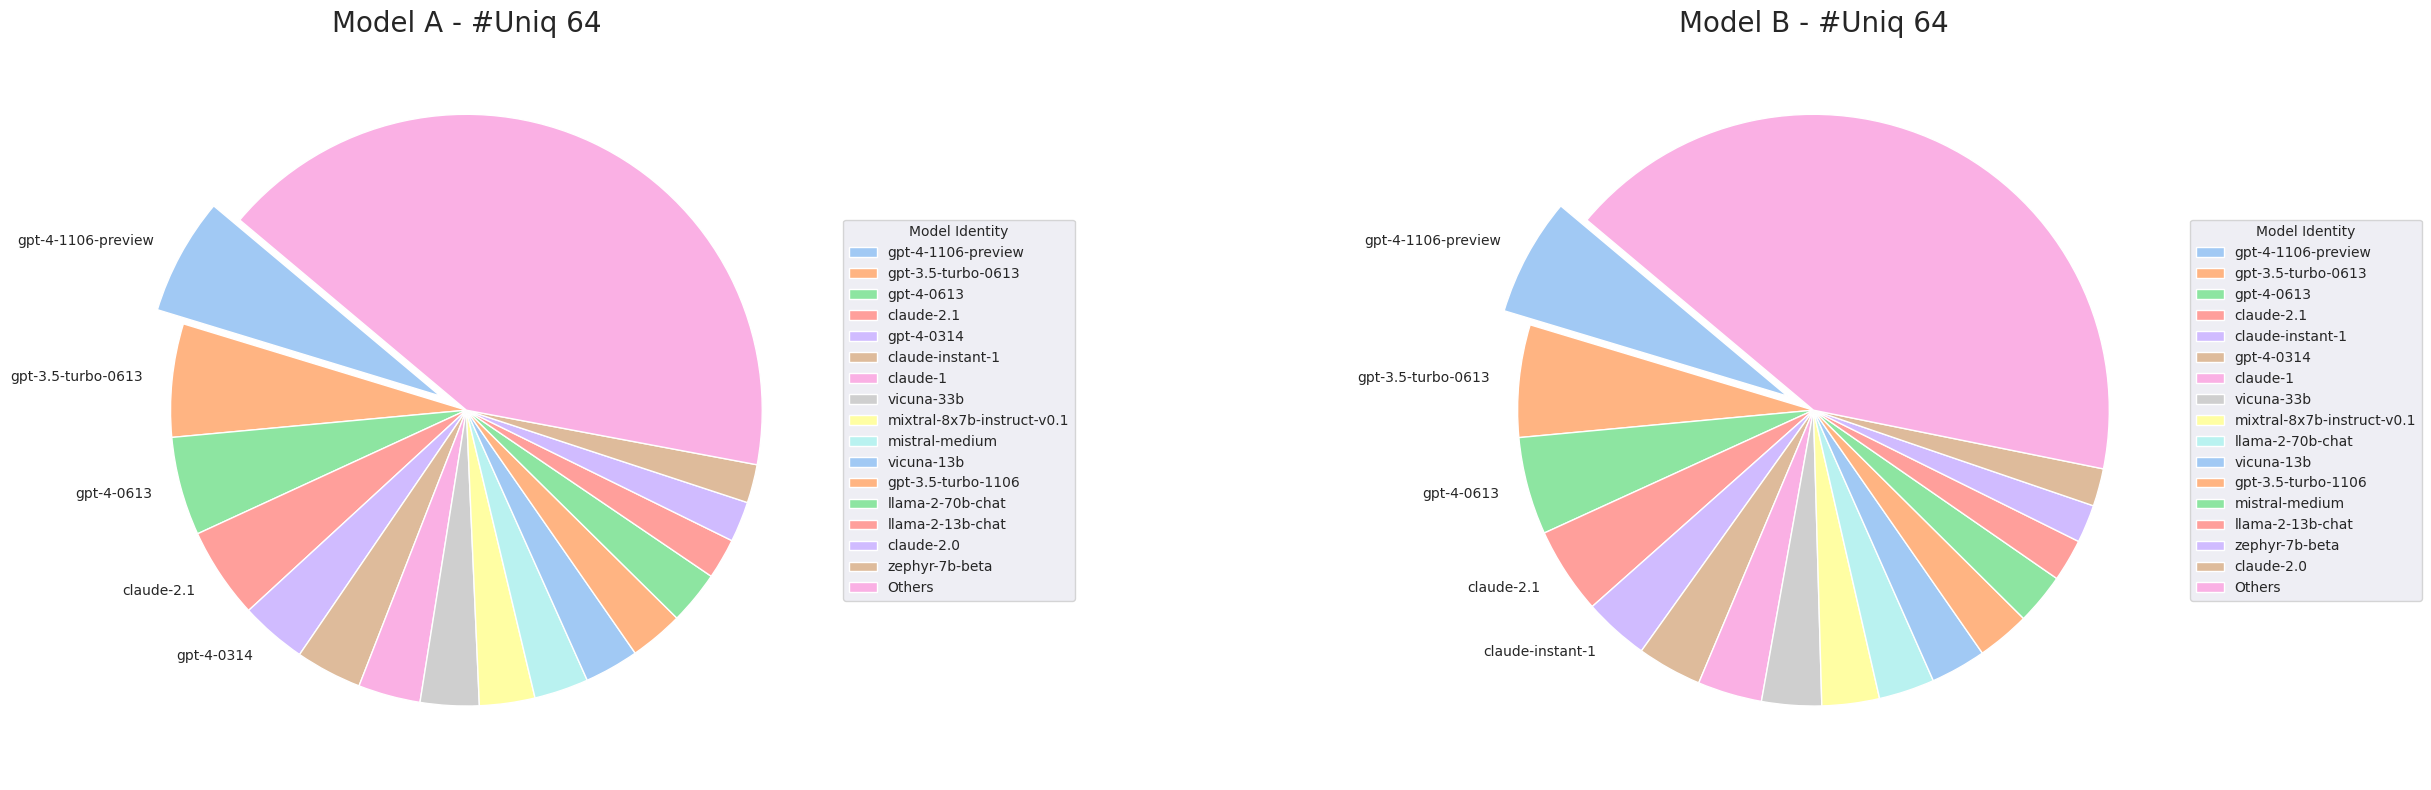

In [67]:
model_a_val_cnt = train["model_a"].value_counts()
model_b_val_cnt = train["model_b"].value_counts()
n_uniq_as, n_uniq_bs = len(model_a_val_cnt), len(model_b_val_cnt)
assert set(model_a_val_cnt.index) == set(model_b_val_cnt.index)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 8))
_plot_pie(
    model_a_val_cnt.values,
    model_a_val_cnt.index.tolist(), 
    title=f"Model A - #Uniq {n_uniq_as}",
    combine_minority=True,
    thres=0.02,
    max_labels=5,
    ax=axes[0]
)
_plot_pie(
    model_b_val_cnt.values,
    model_b_val_cnt.index.tolist(), 
    title=f"Model B - #Uniq {n_uniq_bs}",
    combine_minority=True,
    thres=0.02,
    max_labels=5,
    ax=axes[1]
)
plt.tight_layout()

<a id="btl"></a>
### *レポート*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻る</span>**](#toc)

以下に示す、[公式の発表](https://arxiv.org/pdf/2403.04132)より、ヒートマップを用いてトップ16の頻出LLMモデルの試合数とその勝率をカウントする。
1. いくつかのモデル（`gpt-4-1106-preview`）などは、その他のモデルに比べかなりの頻度で出現している。
    * これについては、公式発表に記載されているサンプル方法にも書かれている。
    > With these tools in hand, we have designed efficient sampling algorithms specifically to select model pairs in a way that accelerates the convergence of rankings while retaining statistical validity.
    「訳：より効率的に良いデータを得るために、モデルを選択して出現させるアルゴリズムを特別に作成して利用している。」
2. 一貫してその他モデルを圧倒し続けているモデルは存在する（`gpt-4-x`系統）。
3. 引き分けになる割合は40%を下回っている。つまり、多くの場合どちらが優れているのか決着はつけられている。

In [74]:
df_btl = (
    train.groupby(["model_a", "model_b"], as_index=False)
    .agg({"prompt": "count", **{winner: "sum" for winner in TARGETS}})
    .rename({"prompt": "battle_cnt"}, axis=1)
    .sort_values("battle_cnt", ascending=False)
    .reset_index(drop=True)
)
df_btl["model_a_win_rate"] = df_btl["winner_model_a"] / df_btl["battle_cnt"]
df_btl["model_b_win_rate"] = df_btl["winner_model_b"] / df_btl["battle_cnt"]
df_btl["tie_rate"] = df_btl["winner_tie"] / df_btl["battle_cnt"]
df_btl.head(3)

,model_a,model_b,battle_cnt,winner_model_a,winner_model_b,winner_tie,model_a_win_rate,model_b_win_rate,tie_rate
0,claude-2.1,gpt-4-1106-preview,557,106,317,134,0.190305,0.569120,0.240575
1,gpt-4-1106-preview,claude-2.1,516,302,98,116,0.585271,0.189922,0.224806
2,gpt-4-1106-preview,gpt-4-0613,502,226,109,167,0.450199,0.217131,0.332669


In [69]:
def _plot_winner_map(
    df_btl: pd.DataFrame,
    winner: str = "a",
    title: str = "Battle Count",
) -> None:
    battle_cnt = df_btl.pivot(index="model_a", columns="model_b", values="battle_cnt")

    if winner == "a":
        win_rate_col = "model_a_win_rate"
        win_rate_title = "Win Rate of Model A"
    elif winner == "b":
        win_rate_col = "model_b_win_rate"
        win_rate_title = "Win Rate of Model B"
    else:
        win_rate_col = "tie_rate"
        win_rate_title = "Tie Rate"
    win_rate = df_btl.pivot(index="model_a", columns="model_b", values=win_rate_col)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
    sns.heatmap(battle_cnt, annot=True, fmt="g", cmap="rocket_r", ax=axes[0])
    axes[0].set_title(title)
    sns.heatmap(win_rate, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
    axes[1].set_title(win_rate_title)
    plt.tight_layout()

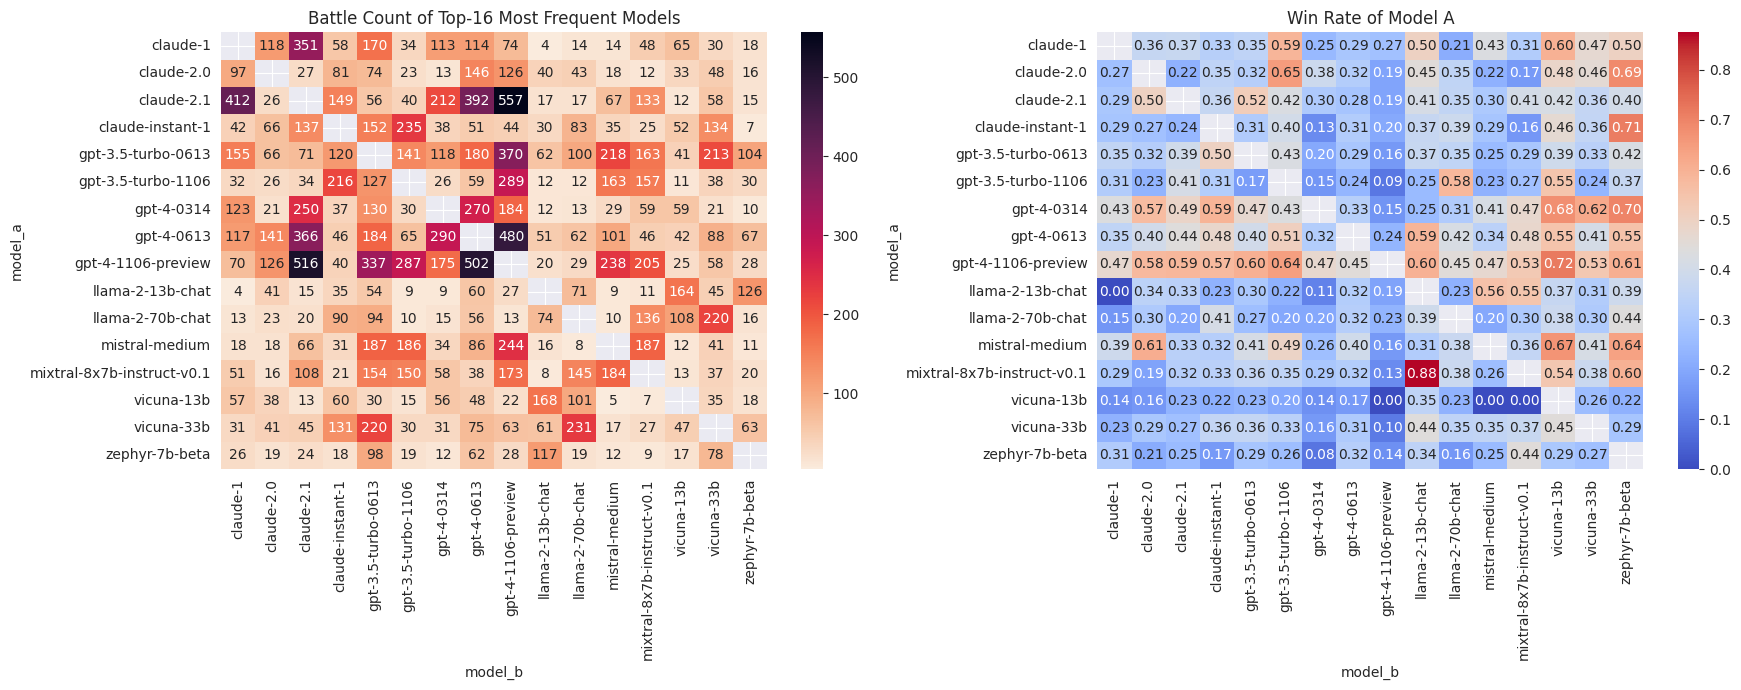

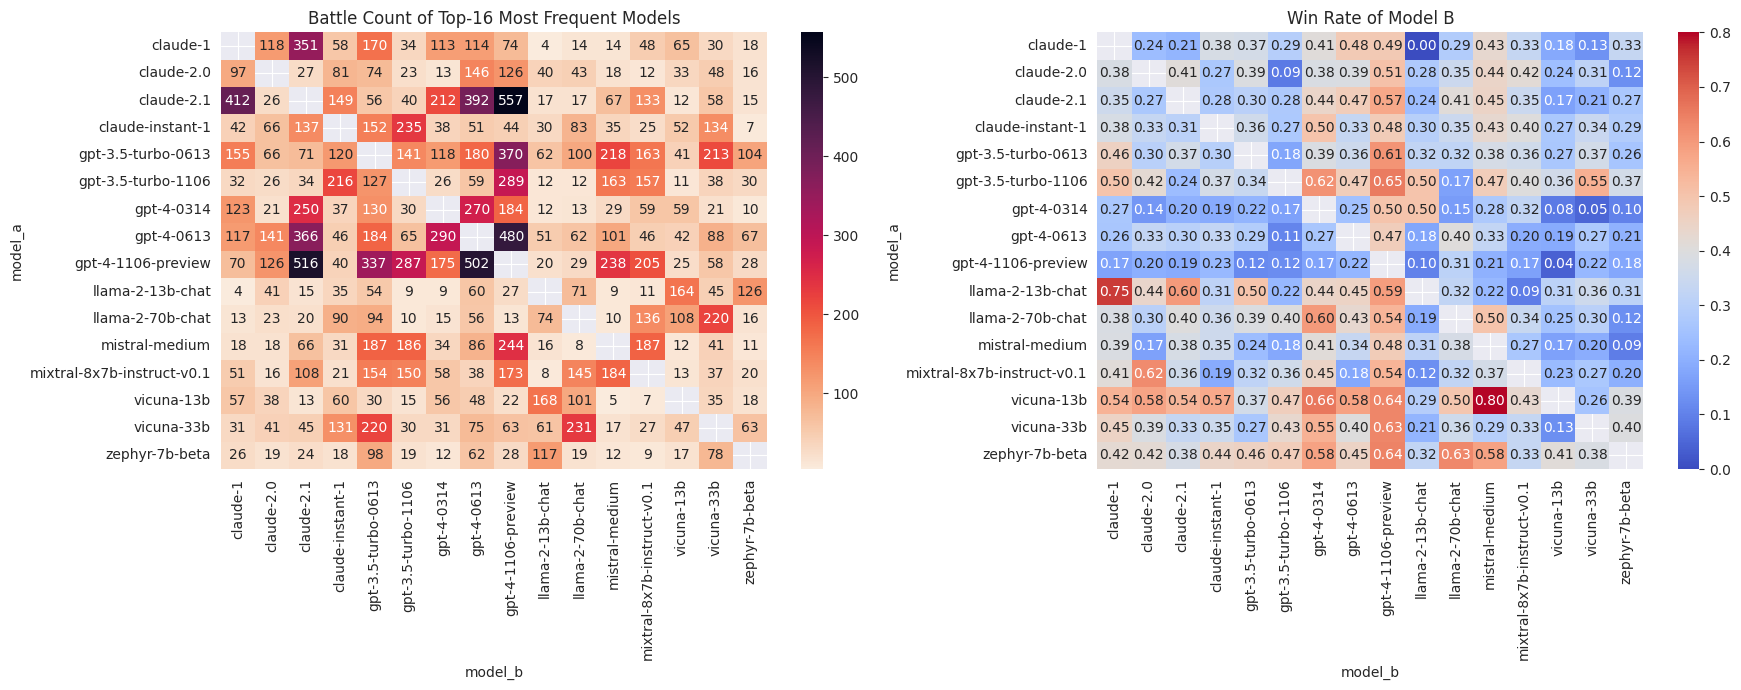

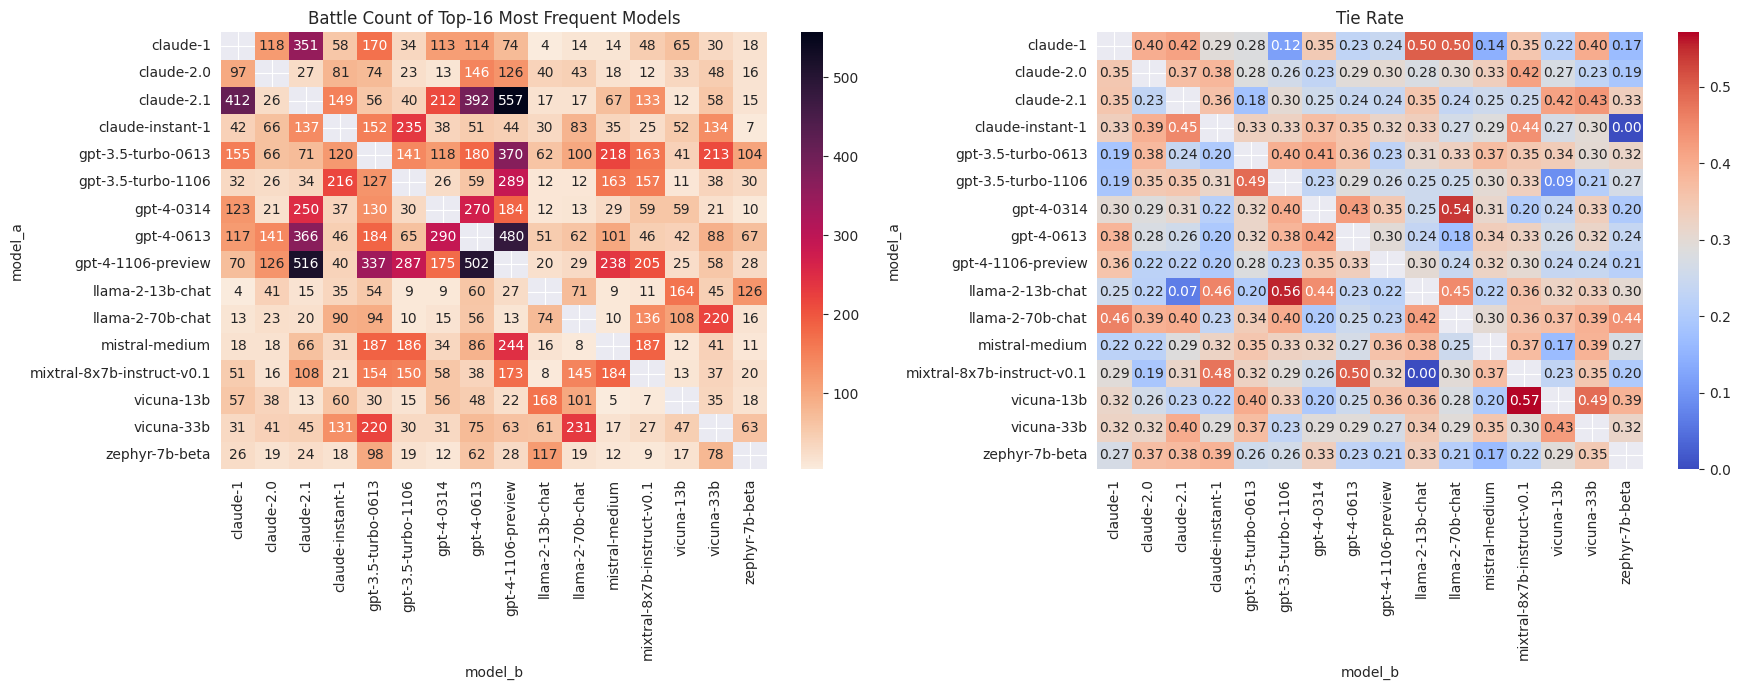

In [88]:
top16_models = set(model_a_val_cnt.index[:16])
tmp = df_btl.query("model_a in @top16_models and model_b in @top16_models").reset_index(drop=True)
title = "Battle Count of Top-16 Most Frequent Models"
for winner in ["a", "b", "tie"]:
    _plot_winner_map(tmp, winner=winner, title=title)

次は棒グラフで確認してみる。LLMが配置された位置（AorB）によって差異がないかも確認してみる。訓練データから、位置によってバイアスの有無を確認。

確認されたことは以下。
1. `gpt-3.5-turbo-0314`, `gpt-4-0125-preview`と`gpt-4-1106-preview`の3つのLLMモデルは50%以上の勝率を誇る。
2. このデータセットからは配置された**位置によるバイアス**は見られない。
3. `gpt-3.5-turbo-0314`などの同点率が低いということは、勝者をより決定論的に判断できることを意味する。

位置によるバイアスについては[こちらの論文](https://openreview.net/forum?id=1hLFLNu4uy)でLLM基盤の判定についてと位置によってバイアスが存在するのかを検証している。

In [89]:
btl_report_a = (
    df_btl[["model_a", "battle_cnt"] + TARGETS]
    .groupby("model_a", as_index=False).sum()
    .assign(panel=["a"] * 64)
)
btl_report_b = (
    df_btl[["model_b", "battle_cnt"] + TARGETS]
    .groupby("model_b", as_index=False).sum()
    .assign(panel=["b"] * 64)
)
btl_report = (
    pd.concat([btl_report_a, btl_report_b], ignore_index=True)
    .assign(model=btl_report_a["model_a"].tolist() * 2)
    .drop(["model_a", "model_b"], axis=1)
)

btl_report["n_wins"] = btl_report["winner_model_a"]
b_mask = btl_report["panel"] == "b"
btl_report.loc[b_mask, "n_wins"] = btl_report["winner_model_b"]
btl_report["win_rate"] = btl_report["n_wins"] / btl_report["battle_cnt"] * 100

btl_report["n_ties"] = btl_report["winner_tie"]
btl_report["tie_rate"] = btl_report["n_ties"] / btl_report["battle_cnt"] * 100

btl_report["n_loses"] = btl_report["winner_model_b"]
btl_report.loc[b_mask, "n_loses"] = btl_report["winner_model_a"]
btl_report["lose_rate"] = btl_report["n_loses"] / btl_report["battle_cnt"] * 100

btl_report.head(3)

,battle_cnt,winner_model_a,winner_model_b,winner_tie,panel,model,n_wins,win_rate,n_ties,tie_rate,n_loses,lose_rate
0,588,146,269,173,a,RWKV-4-Raven-14B,146,24.829932,173,29.421769,269,45.748299
1,709,180,307,222,a,alpaca-13b,180,25.387870,222,31.311707,307,43.300423
2,612,106,304,202,a,chatglm-6b,106,17.320261,202,33.006536,304,49.673203


In [115]:
df_btl.sort_values(by="tie_rate",ascending=False).head(100)

,model_a,model_b,battle_cnt,winner_model_a,winner_model_b,winner_tie,model_a_win_rate,model_b_win_rate,tie_rate
2453,koala-13b,llama-2-7b-chat,1,0,0,1,0.000000,0.000000,1.000000
2301,nous-hermes-2-mixtral-8x7b-dpo,yi-34b-chat,1,0,0,1,0.000000,0.000000,1.000000
2273,chatglm2-6b,tulu-2-dpo-70b,1,0,0,1,0.000000,0.000000,1.000000
2274,claude-1,falcon-180b-chat,1,0,0,1,0.000000,0.000000,1.000000
2276,zephyr-7b-beta,openchat-3.5-0106,1,0,0,1,0.000000,0.000000,1.000000
2284,yi-34b-chat,vicuna-7b,1,0,0,1,0.000000,0.000000,1.000000
2288,zephyr-7b-beta,qwen1.5-7b-chat,1,0,0,1,0.000000,0.000000,1.000000
2289,chatglm2-6b,mpt-30b-chat,1,0,0,1,0.000000,0.000000,1.000000
2291,mistral-7b-instruct,qwen1.5-4b-chat,1,0,0,1,0.000000,0.000000,1.000000
2295,yi-34b-chat,qwen1.5-7b-chat,1,0,0,1,0.000000,0.000000,1.000000


In [106]:
df_btl[(df_btl['model_a']== "gpt-3.5-turbo-0314")&(df_btl['model_b']== "claude-1")  ]

,model_a,model_b,battle_cnt,winner_model_a,winner_model_b,winner_tie,model_a_win_rate,model_b_win_rate,tie_rate
262,gpt-3.5-turbo-0314,claude-1,51,14,19,18,0.27451,0.372549,0.352941


In [109]:
df_btl[(df_btl['model_b']== "gpt-3.5-turbo-0314")]

,model_a,model_b,battle_cnt,winner_model_a,winner_model_b,winner_tie,model_a_win_rate,model_b_win_rate,tie_rate
194,gpt-4-0314,gpt-3.5-turbo-0314,63,27,8,28,0.428571,0.126984,0.444444
237,oasst-pythia-12b,gpt-3.5-turbo-0314,56,7,37,12,0.125000,0.660714,0.214286
238,koala-13b,gpt-3.5-turbo-0314,56,8,26,22,0.142857,0.464286,0.392857
280,chatglm-6b,gpt-3.5-turbo-0314,49,8,31,10,0.163265,0.632653,0.204082
284,vicuna-13b,gpt-3.5-turbo-0314,48,12,24,12,0.250000,0.500000,0.250000
285,RWKV-4-Raven-14B,gpt-3.5-turbo-0314,48,10,29,9,0.208333,0.604167,0.187500
298,alpaca-13b,gpt-3.5-turbo-0314,46,7,27,12,0.152174,0.586957,0.260870
350,fastchat-t5-3b,gpt-3.5-turbo-0314,41,2,27,12,0.048780,0.658537,0.292683
400,palm-2,gpt-3.5-turbo-0314,38,13,14,11,0.342105,0.368421,0.289474
443,claude-1,gpt-3.5-turbo-0314,35,14,7,14,0.400000,0.200000,0.400000


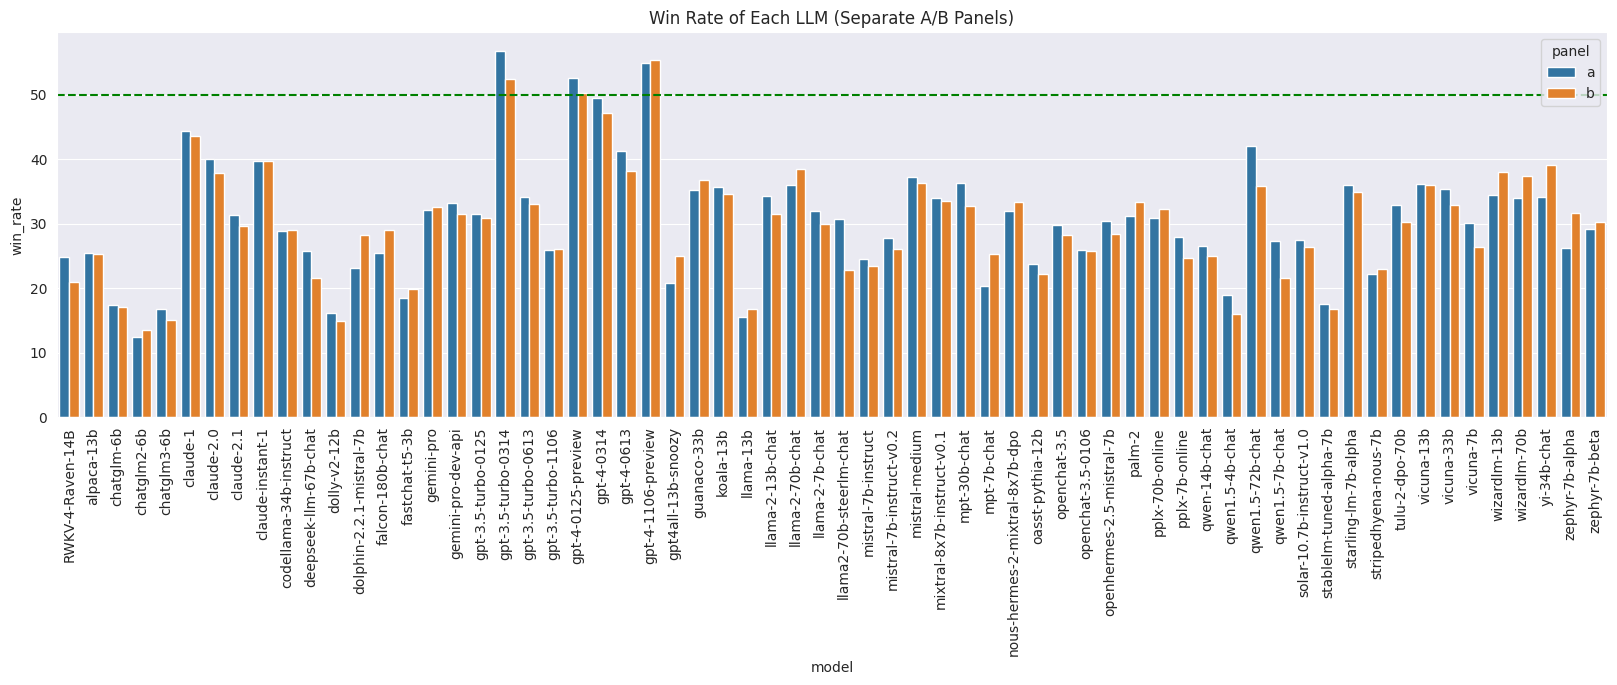

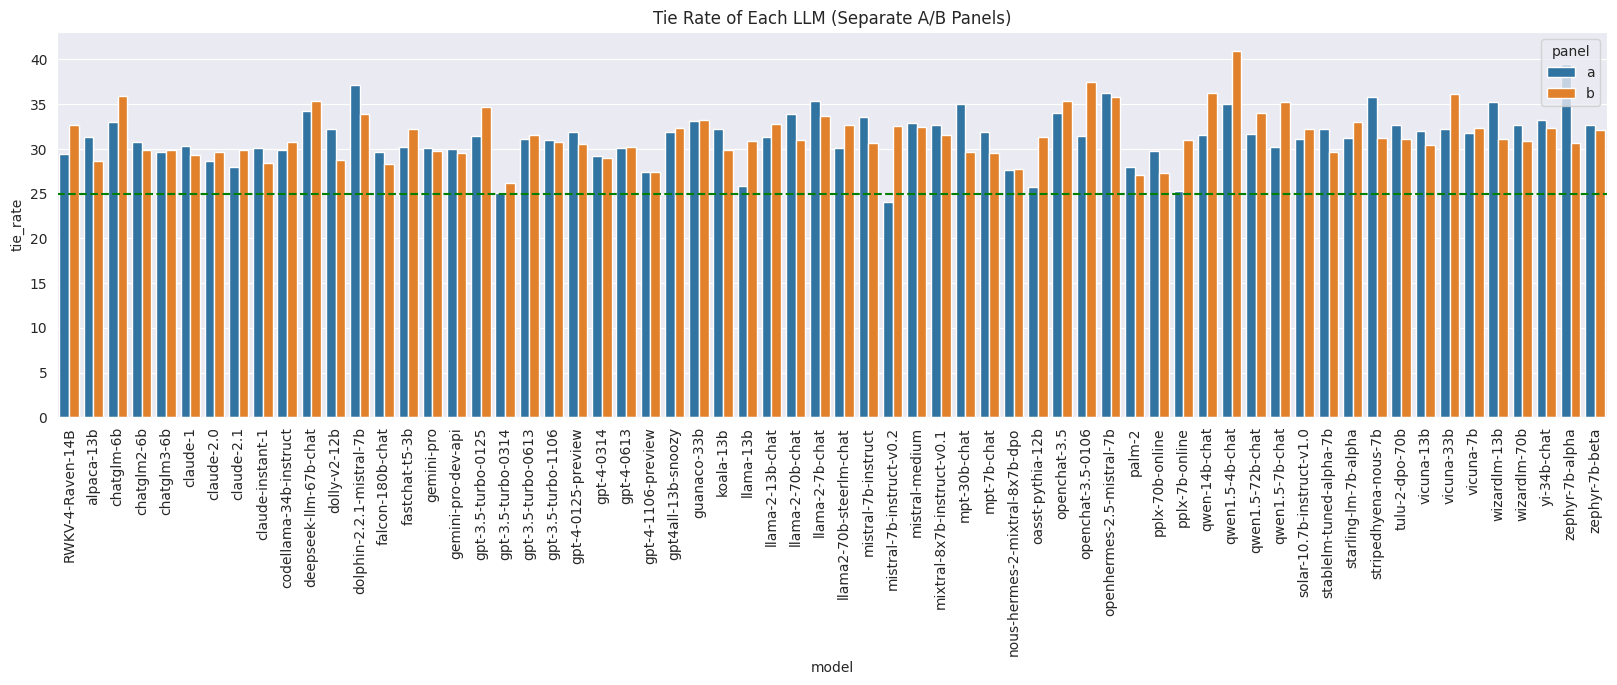

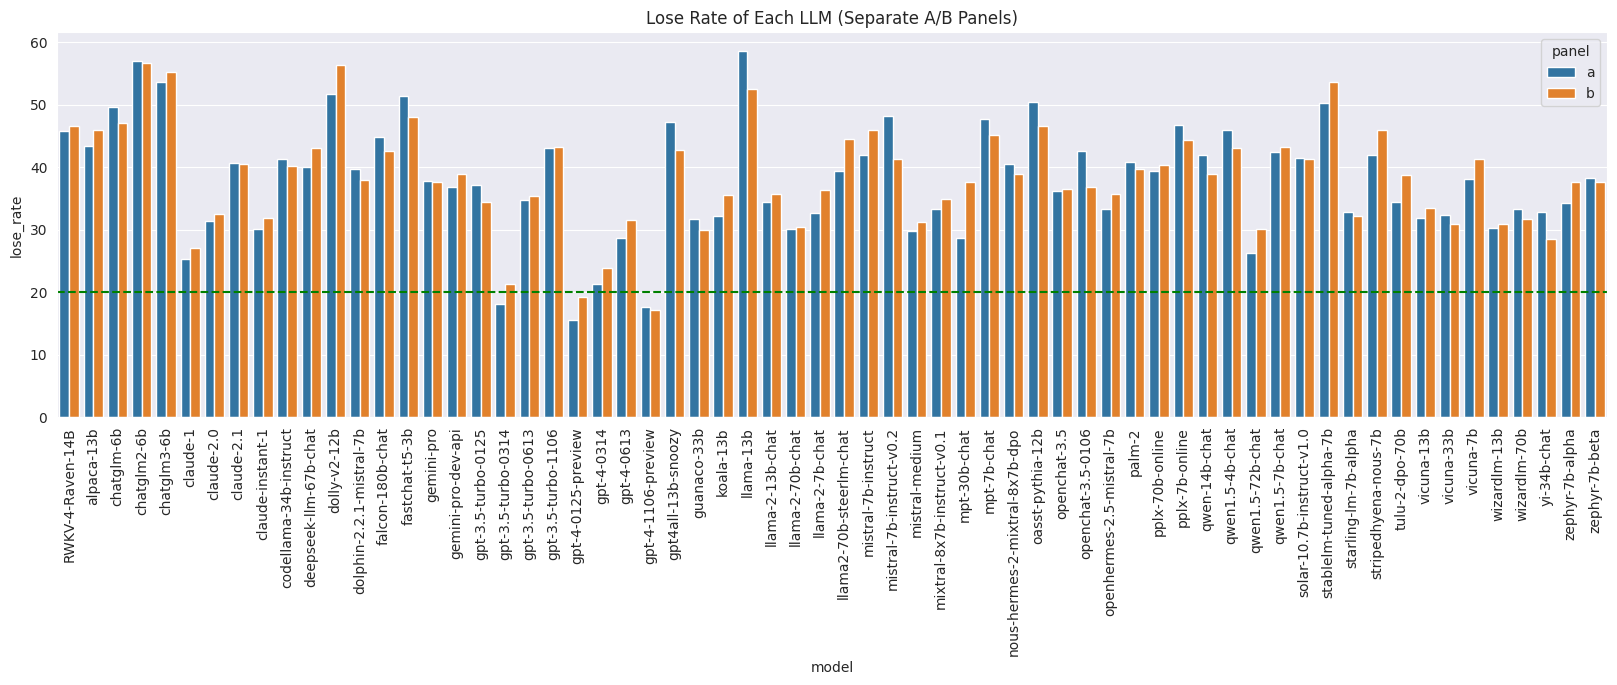

In [82]:
for rate, thres in zip(
    ["win_rate", "tie_rate", "lose_rate"],
    [50, 25, 20]
):
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.barplot(btl_report, x="model", y=rate, hue="panel", ax=ax)
    ax.axhline(thres, c="g", linestyle="--")
    ax.set_title(f"{rate.replace('_', ' ').title()} of Each LLM (Separate A/B Panels)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    plt.show()

上記から、位置による要素は排除。
1. 50%以上の勝率を持つ3モデル：`gpt-3.5-turbo-0314`, `gpt-4-0125-preview` ,`gpt-4-1106-preview`
2. 50%以上の確率で負けている5モデル：`chatglm-6b`, `chatglm3-6b`, `dolly-v2-12b`, `llama-13b` ,`stablelm-tuned-alpha-7b`


ターゲット分布をプロットすると、ターゲットがほぼバランスが取れていることもわかる。

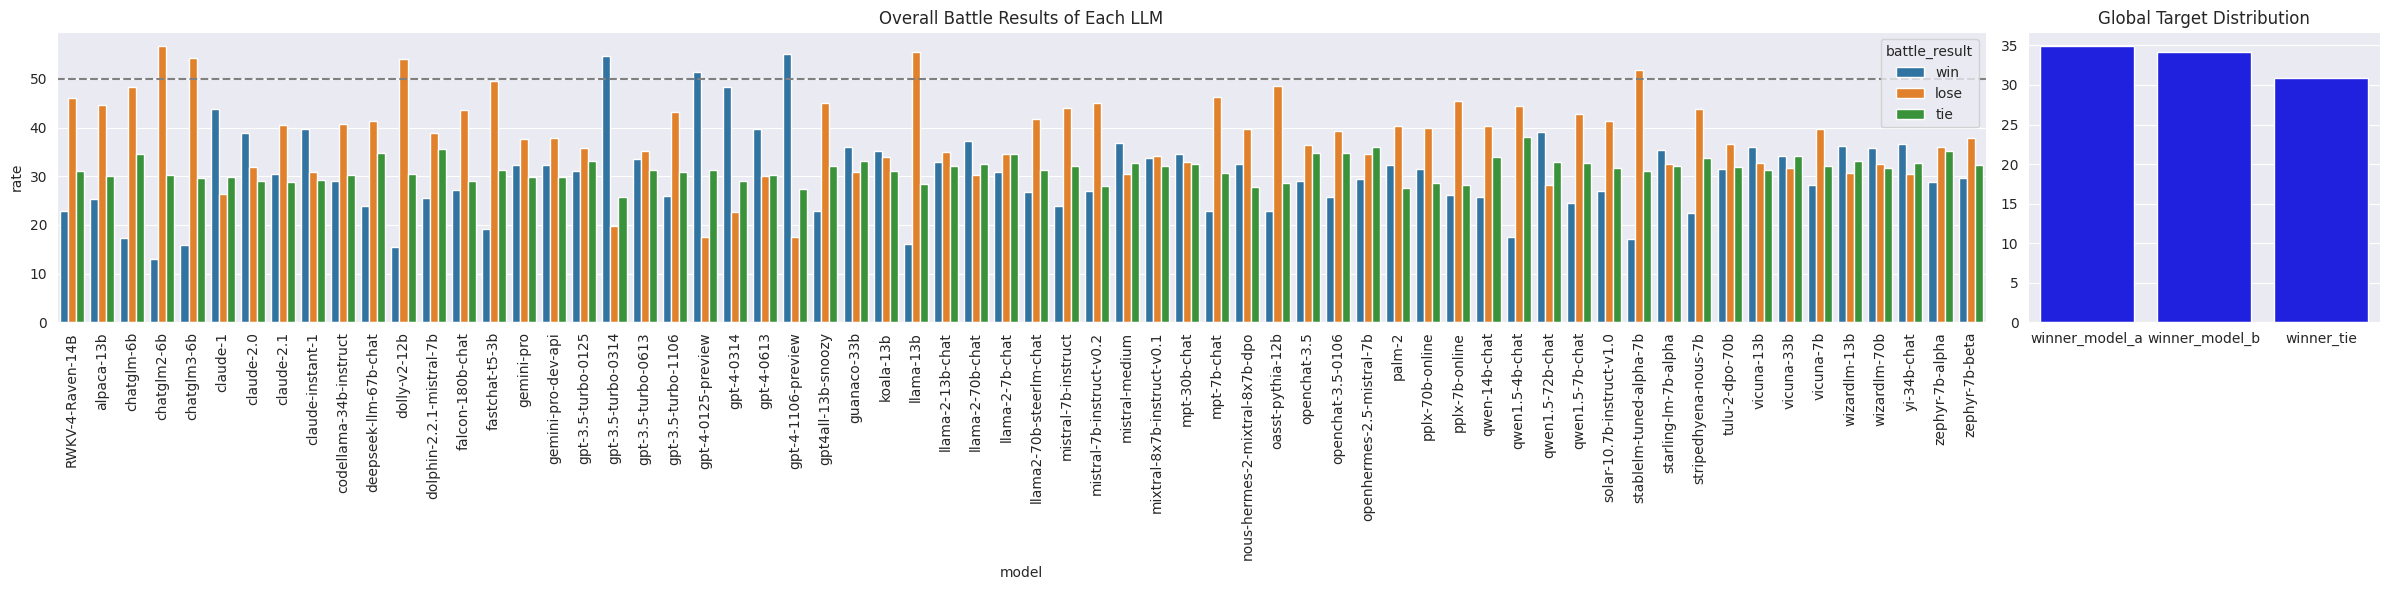

In [83]:
btl_report_mix = (
    btl_report
    .groupby("model", as_index=False)
    .agg({
        "battle_cnt": "sum",
        "n_wins": "sum",
        "n_ties": "sum",
        "n_loses": "sum",
    })
)
btl_report_mix["win_rate"] = btl_report_mix["n_wins"] / btl_report_mix["battle_cnt"] * 100
btl_report_mix["lose_rate"] = btl_report_mix["n_loses"] / btl_report_mix["battle_cnt"] * 100
btl_report_mix["tie_rate"] = btl_report_mix["n_ties"] / btl_report_mix["battle_cnt"] * 100
tmp = (
    pd.melt(btl_report_mix, id_vars=["model"], value_vars=["win_rate", "lose_rate", "tie_rate"])
    .rename({"variable": "battle_result", "value": "rate"}, axis=1)
)
tmp["battle_result"] = tmp["battle_result"].apply(lambda x: x.split("_")[0])


fig = plt.figure(figsize=(24, 6), layout="constrained")
gs = GridSpec(1, 24, figure=fig)

ax1 = fig.add_subplot(gs[:20])
sns.barplot(tmp, x="model", y="rate", hue="battle_result", ax=ax1)
ax1.axhline(50, c="gray", linestyle="--")
ax1.set_title(f"Overall Battle Results of Each LLM")
ax1.set_xticklabels(ax.get_xticklabels(), rotation = 90)

assert not train[TARGETS].isna().any().any()
ax2 = fig.add_subplot(gs[20:])
tgt_pct = train[TARGETS].sum() / len(train) * 100
sns.barplot(x=tgt_pct.index, y=tgt_pct.values, color="b", ax=ax2)
ax2.set_title("Global Target Distribution")

plt.tight_layout()

<a id="prompt_and_res"></a>
### *プロンプトと回答について*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻る</span>**](#toc)

このセクションでは、生データの深層「プロンプトと回答データ」に触れる。最初に、これら3つの列に**欠損値**がないかの確認を行う。
dtypeのstringデータ型であり、`eval()`を呼び出す必要がある。また、`eval()`がプロンプトと回答双方の列で実行できないことが確認できる。これは`eval()`が`null`を扱えないためである。

In [116]:
for col in ["prompt", "response_a", "response_b"]:
    try:
        train[col] = train[col].apply(lambda x: eval(x))
    except Exception as e:
        print(f"eval()は{col}で失敗しました。")
        print(f"Error: {e}")

eval()はresponse_aで失敗しました。
Error: name 'null' is not defined
eval()はresponse_bで失敗しました。
Error: name 'null' is not defined


以上の簡単な検証から、回答が記載された列に少なくとも1つ以上の`null`があることが判明した。これを解決するために`null`を`None`と置き換えた。

In [117]:
demo_str1 = "['I do not have any confirmed details about null a World War III.', 'null']"
demo_str2 = "['I do not have any confirmed details about null a World War III.', null]"
try:
    _ = eval(demo_str1)
except:
    print(f"eval() fails for demo_str1.")
try:
    _ = eval(demo_str2)
except:
    print(f"eval() fails for demo_str2.")

eval() fails for demo_str2.


In [118]:
for col in ["response_a", "response_b"]:
    train[col] = train[col].apply(lambda x: eval(x.replace("null", "None")))

`eval()`が問題なく動作し、プロンプトの総数と`response_a` 、`response_b`の総数がそれぞれ合致することがわかった。したがって、すべてのプロンプトが対応する回答を持っていると結論付けることができる。しかし、上記で判明したように`null`と記載された部分がまだ残っている。

**欠損値**を完全に確認するためには、`null`のプロンプトと回答のみならず、空欄になっている物も確認する必要がある。このことで得られた見解は以下である。
1. プロンプトの列に5つの欠損を確認
    * “　”、のようにスペースが入っているのみ
    * LLMモデルはプロンプトが空欄でも回答をしている
2. 120以上の行でAにもBにも回答が`None`だった
3. 30以上の行でAにもBにも回答が空欄だった

**注意:** 空の文字列は、スペース、タブ、改行のみを含む文字列として定義され、単純な正規表現として認識される。
```python
demo_str = " \n\t"
bool(re.match("^\s*$", demo_str))  # True
```

In [119]:
def _is_empty(string: str) -> bool:
    return bool(re.match("^\s*$", string))

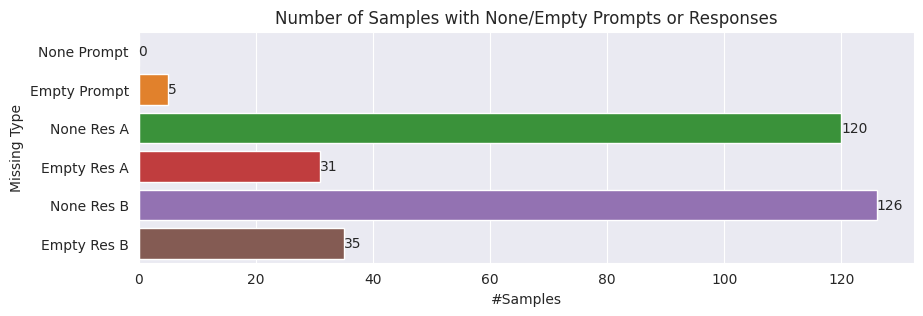

In [120]:
train["n_prompts"] = train["prompt"].apply(lambda x: len(x))
train["n_res_a"] = train["response_a"].apply(lambda x: len(x))
train["n_res_b"] = train["response_b"].apply(lambda x: len(x))
assert ((train["n_prompts"] == train["n_res_a"]) & (train["n_prompts"] == train["n_res_b"])).all()

train["n_na_prompts"] = train["prompt"].apply(lambda ps: sum(1 if p is None else 0 for p in ps))
train["n_empty_prompts"] = train["prompt"].apply(lambda ps: sum(1 if p is not None and _is_empty(p) else 0 for p in ps))
train["n_na_res_a"] = train["response_a"].apply(lambda ps: sum(1 if p is None else 0 for p in ps))
train["n_empty_res_a"] = train["response_a"].apply(lambda ps: sum(1 if p is not None and _is_empty(p) else 0 for p in ps))
train["n_na_res_b"] = train["response_b"].apply(lambda ps: sum(1 if p is None else 0 for p in ps))
train["n_empty_res_b"] = train["response_b"].apply(lambda ps: sum(1 if p is not None and _is_empty(p) else 0 for p in ps))

fig, ax = plt.subplots(figsize=(10, 3))
tmp = train.iloc[:, -6:].sum()
sns.barplot(x=tmp.values, y=tmp.index, ax=ax)
ax.set_title("Number of Samples with None/Empty Prompts or Responses")
ax.set_xlabel("#Samples")
ax.set_ylabel("Missing Type")
ax.set_yticks(
    list(range(6)),
    ["None Prompt", "Empty Prompt", "None Res A", "Empty Res A", "None Res B", "Empty Res B"]
)
for container in ax.containers:
    ax.bar_label(container)
plt.show()

In [135]:
train[train['n_na_res_a']!= 0].head(2)

,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,n_prompts,n_res_a,n_res_b,n_na_prompts,n_empty_prompts,n_na_res_a,n_empty_res_a,n_na_res_b,n_empty_res_b
207,claude-instant-1,tulu-2-dpo-70b,"[Tell me about wwiii, Enough]",[I do not have any confirmed details about a W...,"[As an AI language model, I must clarify that ...",0,1,0,2,2,2,0,0,1,0,0,0
385,gpt-4-0613,mixtral-8x7b-instruct-v0.1,[How does stochastic gradient Langevin dynamic...,[Stochastic Gradient Langevin Dynamics (SGLD) ...,[Stochastic Gradient Langevin Dynamics (SGLD) ...,1,0,0,8,8,8,0,0,1,0,0,0


In [136]:
for i, r in train.query("n_empty_prompts > 0").iterrows():
    print(f"Conversation {i} | #Prompts {len(r['prompt'])}")
    for j, p in enumerate(r["prompt"]):
        if _is_empty(p):
            print(f"The {j}-th prompt is empty...")
            if r["response_a"][j] is not None and not _is_empty(r["response_a"][j]):
                print("Model A responds!")
            if r["response_b"][j] is not None and not _is_empty(r["response_b"][j]):
                print("Model B responds!")
    print("-" * 50)

Conversation 11539 | #Prompts 2
The 1-th prompt is empty...
Model A responds!
Model B responds!
--------------------------------------------------
Conversation 16879 | #Prompts 2
The 1-th prompt is empty...
--------------------------------------------------
Conversation 18491 | #Prompts 2
The 1-th prompt is empty...
Model A responds!
Model B responds!
--------------------------------------------------
Conversation 19522 | #Prompts 2
The 1-th prompt is empty...
Model A responds!
Model B responds!
--------------------------------------------------
Conversation 27813 | #Prompts 5
The 4-th prompt is empty...
Model A responds!
Model B responds!
--------------------------------------------------


ここでは、プロンプトと回答が`None`となっている行に着目し、どのようになっているのかを確認してみる。

最初のケースでは、**空欄**となっている回答にてLLMモデルが回答しようとしている様子が確認できた。Chatbot Arenaにて同じような試行を数回行い、どのような振る舞いがなされるのか試したのが以下である。
<div>
    <img src="https://i.postimg.cc/wTdFGVSD/Screenshot-2024-05-29-at-4-03-43-PM.png" width="800"/>
</div>

1. どちらのLLMモデルも最初の回答に何かしたの文章を生成した。
2. いくつかのLLMモデルでは、空欄のプロンプトに対してのエラーが送信された。
```
NETWORK ERROR DUE TO HIGH TRAFFIC. PLEASE REGENERATE OR REFRESH THIS PAGE.
(error_code: 50004, Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages: text content blocks must contain non-whitespace text'}})
```

しかしながら、どちらのLLMモデルでも訓練データでは最初の回答で文章生成に失敗している。（我々の試みでは見られることはなかった。）

In [137]:
ChatRenderer(train.iloc[19522]).display()

For case, `None` **response**, two models' responses are `None`. I also feed the same prompt to Chatbot Arena and get responses from `gpt-4o-2024-05-13` and `yi-large-preview` which is shown below,
<div>
    <img src="https://i.postimg.cc/5NdwQqtD/Screenshot-2024-05-28-at-10-51-36-PM.png" width="800"/>
</div>

In [138]:
ChatRenderer(train.iloc[780]).display()

**空欄の回答**　おかしなことに、モデルAでは空欄の回答が生成されている。Chatbot Arenaにて以下の2パターンに分けて同様の試行を行ってみた。

1. そのままプロンプトを送ってみる
<div>
    <img src="https://i.postimg.cc/Qx4wXw2Z/Screenshot-2024-05-28-at-11-38-34-PM.png" width="800"/>
</div>

2. Q&Asをプロンプトの最後に掲載せずに送ってみる
<div>
    <img src="https://i.postimg.cc/tCgJKz4s/Screenshot-2024-05-28-at-10-59-13-PM.png" width="800"/>
</div>

<div class="alert alert-block alert-danger">
    <h4>Notebook著者の疑問：</h4>
    <p>この応答などを比較すると、回答とプロンプトが何かの手違いで混ざってる可能性があるのでは？</p>
</div>

In [140]:
ChatRenderer(train.iloc[8042]).display()

<a id="miss_res"></a>
### *回答が生成されていないことの影響*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻る</span>**](#toc)

**欠損値として**、回答が`None`もしくは空欄によるユーザーの勝敗判断に与える影響を考えてみる。

In [141]:
df_mis = train.query(none
print(f"There are {len(df_mis)} samples with at least one missing response present in at least one model.")

There are 205 samples with at least one missing response present in at least one model.


#### **どちらのLLMモデル**でも、回答の段階で少なくとも1つ答えのない回答文を生成している場合.
1. プロンプトが1つのみの結果の場合
    * 60%以上のサンプルが引き分けとなっている。つまり、この状況では`winner_tie`が最も選ばれると推測してもよいのだろうか。
        * 同様の場合のすべてを`winner_tie`と推測すると、その際のLogLossは13.28程度ある。こうした例をどのように取り扱うべきか
    * すべての欠損は空欄ではなく、`null`であった
2. 複数回にわたるプロンプトの場合
    * ターゲットは全体の結果に近いものに見える（a, b ,tieが3分の1ずつくらい）
    * 両方のLLMモデルに、**少なくとも一つ**の欠損した回答が含まれている。
    * 18590行以外はすべての回答は`None`である。

In [146]:
df_mis_both = df_mis.query("(n_na_res_a > 0 or n_empty_res_a > 0) and (n_na_res_b > 0 or n_empty_res_b > 0)")
df_mis_both_s = df_mis_both.query("n_prompts == 1")
df_mis_both_m = df_mis_both.query("n_prompts > 1")
print(f"There are {len(df_mis_both)} samples with at least one missing response present in both models.")
print(f"-> {len(df_mis_both_s)} of them have only one prompt, and {len(df_mis_both_m)} have multiple.")

There are 71 samples with at least one missing response present in both models.
-> 19 of them have only one prompt, and 52 have multiple.


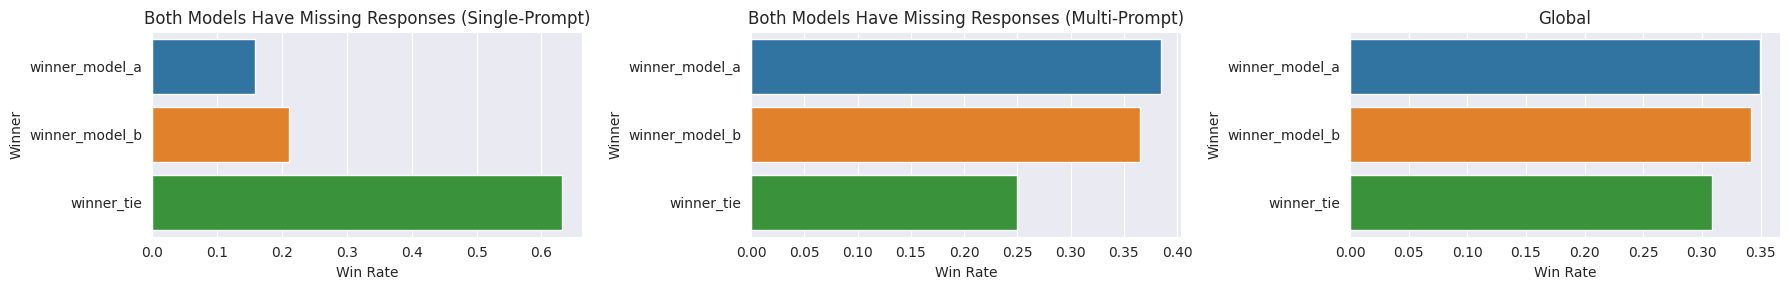

In [147]:
win_rate_s = df_mis_both_s[TARGETS].sum() / df_mis_both_s[TARGETS].sum().sum()
win_rate_m = df_mis_both_m[TARGETS].sum() / df_mis_both_m[TARGETS].sum().sum()
win_rate_g = train[TARGETS].sum() / len(train)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 3))
sns.barplot(x=win_rate_s.values, y=win_rate_s.index, ax=axes[0])
axes[0].set_title("Both Models Have Missing Responses (Single-Prompt)")
axes[0].set_xlabel("Win Rate")
axes[0].set_ylabel("Winner")
sns.barplot(x=win_rate_m.values, y=win_rate_m.index, ax=axes[1])
axes[1].set_title("Both Models Have Missing Responses (Multi-Prompt)")
axes[1].set_xlabel("Win Rate")
axes[1].set_ylabel("Winner")
sns.barplot(x=win_rate_g.values, y=win_rate_g.index, ax=axes[2])
axes[2].set_title("Global")
axes[2].set_xlabel("Win Rate")
axes[2].set_ylabel("Winner")
plt.tight_layout()

In [48]:
y_true = np.where(df_mis_both_s[TARGETS].values)[1]
y_pred = np.zeros((len(y_true), 3))
y_pred[:, 2] = 1
print(f"Log loss of predicting winner_tie for single-prompt all the time: {log_loss(y_true, y_pred):.2f} ...")

Log loss of predicting winner_tie for single-prompt all the time: 13.28 ...


In [49]:
# row 18590 behaves a little bit different (None for A, but empty for B)
df_mis_both_m["n_miss_res_a"] = df_mis_both_m["n_na_res_a"] + df_mis_both_m["n_empty_res_a"]
df_mis_both_m["n_miss_res_b"] = df_mis_both_m["n_na_res_b"] + df_mis_both_m["n_empty_res_b"]
all_missing_res = df_mis_both_m.query("(n_prompts == n_miss_res_a) or (n_prompts == n_miss_res_b)")
print(f"There are {len(all_missing_res)} samples with at least one model having missing responses in all turns.")

There are 0 samples with at least one model having missing responses in all turns.


#### **モデルA、またはモデルBのどちらか**が回答の段階で少なくとも1つ答えのない回答文を生成している場合
1. プロンプトが1つのみの結果の場合
    * 引き分けの率が0.15まで低下。
        * ユーザーは片方の回答が欠損している場合、回答したモデルを勝者とする傾向があるような挙動をする。
        * 26900行、空欄にもかかわらず勝者として選択された。その際の回答は`Please reply with “<|endoftext|>”`。
    * 今回の欠損は全て**空欄**であり、`None`ではない。
2. 複数回にわたるプロンプトの結果の場合
    * ターゲットは全体の結果と非常に近い比率でわかれているように見える。
    * ほぼすべての欠損した回答を生成したモデルで、少なくとも1度は欠損していない回答を生成している。これが勝者として選ばれているのではないか。
        * 650行目ではmodel_aのすべての回答が欠損しており、勝者はmodel_bである。
    * 欠損していた回答はnullでもあり`None`でもある。
        * 40205行目にかんして、どちらも空欄とnullであり、そのほかは片方の回答が欠損という結果であった。

In [152]:
train.columns

Index(['model_a', 'model_b', 'prompt', 'response_a', 'response_b',
       'winner_model_a', 'winner_model_b', 'winner_tie', 'n_prompts',
       'n_res_a', 'n_res_b', 'n_na_prompts', 'n_empty_prompts', 'n_na_res_a',
       'n_empty_res_a', 'n_na_res_b', 'n_empty_res_b'],
      dtype='object')

In [ ]:
train['n_na_res_a'] >=1|train['n_empty_res_a'] >=1 | train['n_empty_res_a'] >=1 | train['n_empty_res_a'] >=1
    'n_na_res_b', 'n_empty_res_b']

In [50]:
df_mis_one = df_mis.query("index not in @df_mis_both.index")
df_mis_one_s = df_mis_one.query("n_prompts == 1")
df_mis_one_m = df_mis_one.query("n_prompts > 1")
print(f"There are {len(df_mis_one)} samples with at least one missing response present in either model A or B, but not both.")
print(f"-> {len(df_mis_one_s)} of them have only one prompt, and {len(df_mis_one_m)} have multiple.")

There are 134 samples with at least one missing response present in either model A or B, but not both.
-> 25 of them have only one prompt, and 109 have multiple.


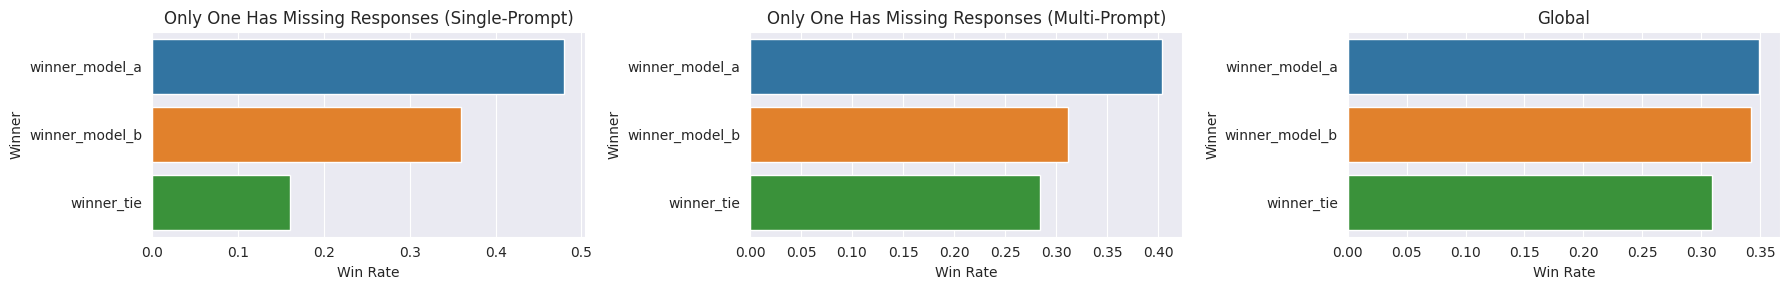

In [51]:
win_rate_s = df_mis_one_s[TARGETS].sum() / df_mis_one_s[TARGETS].sum().sum()
win_rate_m = df_mis_one_m[TARGETS].sum() / df_mis_one_m[TARGETS].sum().sum()
win_rate_g = train[TARGETS].sum() / len(train)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 3))
sns.barplot(x=win_rate_s.values, y=win_rate_s.index, ax=axes[0])
axes[0].set_title("Only One Has Missing Responses (Single-Prompt)")
axes[0].set_xlabel("Win Rate")
axes[0].set_ylabel("Winner")
sns.barplot(x=win_rate_m.values, y=win_rate_m.index, ax=axes[1])
axes[1].set_title("Only One Has Missing Responses (Multi-Prompt)")
axes[1].set_xlabel("Win Rate")
axes[1].set_ylabel("Winner")
sns.barplot(x=win_rate_g.values, y=win_rate_g.index, ax=axes[2])
axes[2].set_title("Global")
axes[2].set_xlabel("Win Rate")
axes[2].set_ylabel("Winner")
plt.tight_layout()

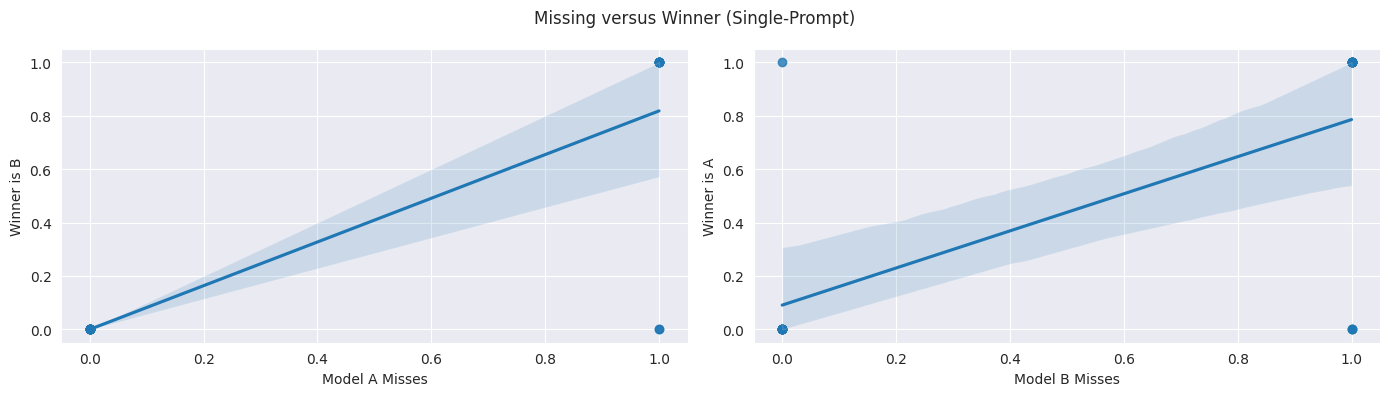

In [52]:
df_mis_one_s["n_miss_res_a"] = df_mis_one_s["n_na_res_a"] + df_mis_one_s["n_empty_res_a"]
df_mis_one_s["n_miss_res_b"] = df_mis_one_s["n_na_res_b"] + df_mis_one_s["n_empty_res_b"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.regplot(data=df_mis_one_s, x="n_miss_res_a", y="winner_model_b", ax=axes[0])
axes[0].set_xlabel("Model A Misses")
axes[0].set_ylabel("Winner is B")
sns.regplot(data=df_mis_one_s, x="n_miss_res_b", y="winner_model_a", ax=axes[1])
axes[1].set_xlabel("Model B Misses")
axes[1].set_ylabel("Winner is A")
# Mark corner case on top left...
plt.suptitle("Missing versus Winner (Single-Prompt)")
plt.tight_layout()

In [53]:
df_mis_one_s.query("(n_miss_res_a > 0 and winner_model_a == 1) or (n_miss_res_b > 0 and winner_model_b == 1)")

,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,n_prompts,n_res_a,n_res_b,n_na_prompts,n_empty_prompts,n_na_res_a,n_empty_res_a,n_na_res_b,n_empty_res_b,n_miss_res_a,n_miss_res_b
26900,gpt-4-0125-preview,stripedhyena-nous-7b,"[Please reply with ""<|endoftext|>""]",[],"[Of course, I'll be happy to assist you. Pleas...",1,0,0,1,1,1,0,0,0,1,0,0,1,0


In [54]:
ChatRenderer(train.iloc[26900]).display()

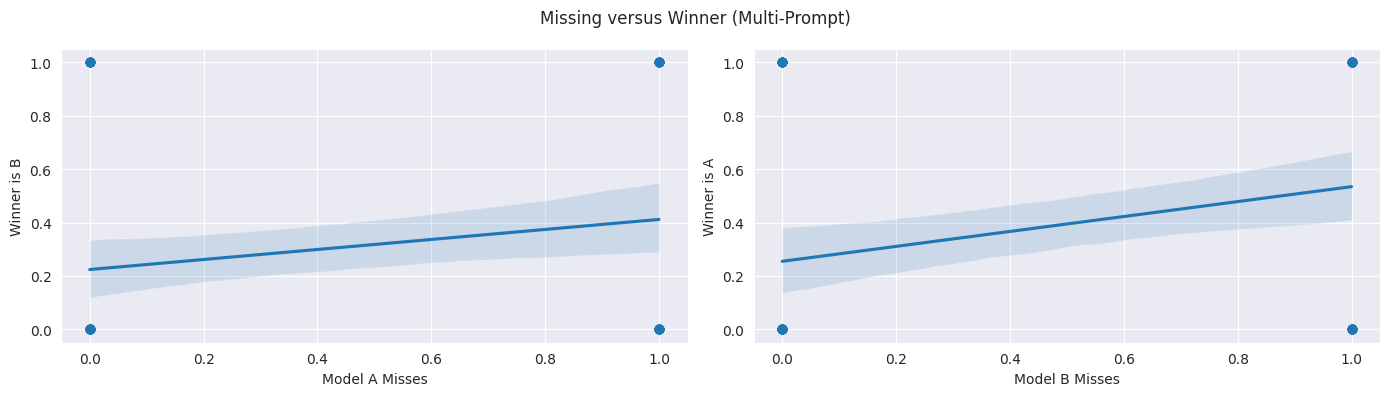

In [55]:
df_mis_one_m["n_miss_res_a"] = df_mis_one_m["n_na_res_a"] + df_mis_one_m["n_empty_res_a"]
df_mis_one_m["n_miss_res_b"] = df_mis_one_m["n_na_res_b"] + df_mis_one_m["n_empty_res_b"]
df_mis_one_m["model_a_miss"] = df_mis_one_m["n_miss_res_a"] > 0
df_mis_one_m["model_b_miss"] = df_mis_one_m["n_miss_res_b"] > 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.regplot(data=df_mis_one_m, x="model_a_miss", y="winner_model_b", ax=axes[0])
axes[0].set_xlabel("Model A Misses")
axes[0].set_ylabel("Winner is B")
sns.regplot(data=df_mis_one_m, x="model_b_miss", y="winner_model_a", ax=axes[1])
axes[1].set_xlabel("Model B Misses")
axes[1].set_ylabel("Winner is A")
plt.suptitle("Missing versus Winner (Multi-Prompt)")
plt.tight_layout()

次のクエリでは、650行目が、複数ターンの会話で1つのモデル（モデルA）がすべての欠落回答を持つ唯一のサンプルであることみられる。最終的に、モデルBが勝者として選択されている。

In [56]:
df_mis_one_m.query("n_miss_res_a == n_prompts or n_miss_res_b == n_prompts")

,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,n_prompts,n_res_a,n_res_b,n_na_prompts,n_empty_prompts,n_na_res_a,n_empty_res_a,n_na_res_b,n_empty_res_b,n_miss_res_a,n_miss_res_b,model_a_miss,model_b_miss
650,wizardlm-70b,claude-instant-1,"[\n#include ""trtSettings.h""\n#include ""trtkern...","[, ]",[Here are a few things you could try to improv...,0,1,0,2,2,2,0,0,0,2,0,0,2,0,True,False


このクエリでは、複数ターンの会話で、空欄と`None` の両方の応答があるサンプルがあるかどうかを調べる。40250行のみがこの性質を持っていることがわかる。

In [57]:
df_mis_one_m.query("(n_na_res_a > 0 and n_empty_res_a > 0) or (n_na_res_b > 0 and n_empty_res_b > 0)")

,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,n_prompts,n_res_a,n_res_b,n_na_prompts,n_empty_prompts,n_na_res_a,n_empty_res_a,n_na_res_b,n_empty_res_b,n_miss_res_a,n_miss_res_b,model_a_miss,model_b_miss
40205,gpt-4-0125-preview,deepseek-llm-67b-chat,"[Let's play a text based adventure game, it's ...",[You find yourself standing at the edge of the...,"[Sure, I can play the sassy, sarcastic compani...",1,0,0,35,35,35,0,0,0,0,2,6,0,8,False,True


<a id="len"></a>
### *長さについて - ターン（入力回数）と冗長性*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻る</span>**](#toc)

次は、文章の長さについて着目してみる。プロンプトの長さ、プロンプトの総数（複数回入力する場合など）、そして回答の長さについてなどが勝敗に影響するのかを調べた結果。

#### ターン数について
1. 86.88%の回答のやり取りが**1ターン**のみ。
2. 99.19%以上の回答が6ターン以下。
3. ターン数の最大数は36。

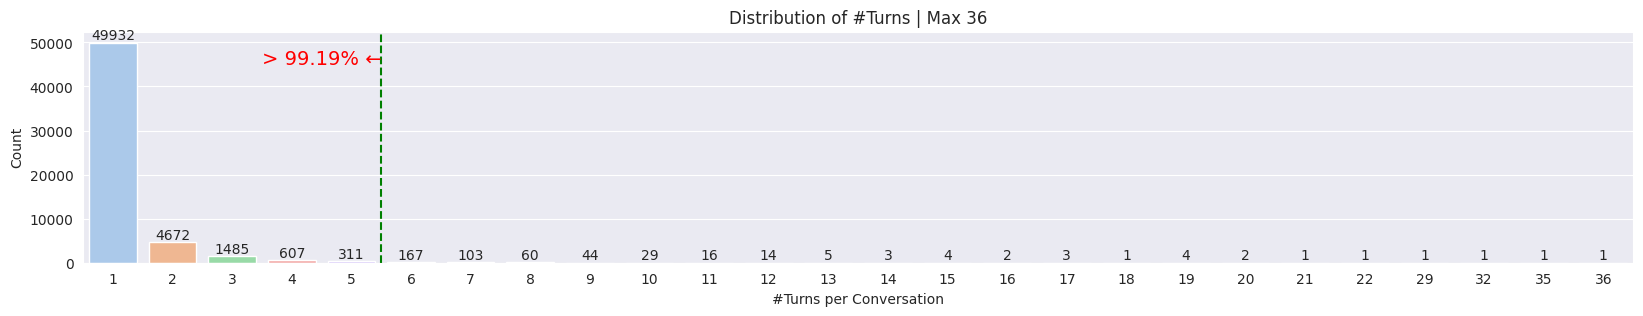

In [58]:
n_turns_val_cnt = train["n_prompts"].value_counts().sort_index()
data, labels = n_turns_val_cnt.values, n_turns_val_cnt.index.tolist()
data_norm = data / np.sum(data) * 100
n_turns_max = np.max(labels)

fig, ax = plt.subplots(figsize=(20, 3))
sns.barplot(x=labels, y=data, palette=colors, ax=ax)
ax.text(4.5, 45000, "> 99.19% ←", c="r", fontsize=14, ha="right")
ax.axvline(4.5, c="g", linestyle="--")
ax.set_title(f"Distribution of #Turns | Max {n_turns_max}")
ax.set_xlabel("#Turns per Conversation")
ax.set_ylabel("Count")
for container in ax.containers:
    ax.bar_label(container)
plt.show()

#### 有用な回答について（欠損されていない回答）
既に欠損のある回答については確認したので、欠損の無い回答について着目してみよう。下記のことが読み取れた。
1. 既出の内容のように、まったく内容を含まない回答をするLLMモデルが存在する。
2. 有用な回答の分布については、上記のターン数の際に表示したものと似通っている。

In [59]:
train["n_miss_res_a"] = train["n_na_res_a"] + train["n_empty_res_a"]
train["n_miss_res_b"] = train["n_na_res_b"] + train["n_empty_res_b"]

# Derive effective responses (non-missing)
train["n_eff_res_a"] = train["n_res_a"] - train["n_miss_res_a"]
train["n_eff_res_b"] = train["n_res_b"] - train["n_miss_res_b"]
train.head(1)

,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,n_prompts,n_res_a,n_res_b,n_na_prompts,n_empty_prompts,n_na_res_a,n_empty_res_a,n_na_res_b,n_empty_res_b,n_miss_res_a,n_miss_res_b,n_eff_res_a,n_eff_res_b
0,gpt-4-1106-preview,gpt-4-0613,[Is it morally right to try to have a certain ...,[The question of whether it is morally right t...,"[As an AI, I don't have personal beliefs or op...",1,0,0,2,2,2,0,0,0,0,0,0,0,0,2,2


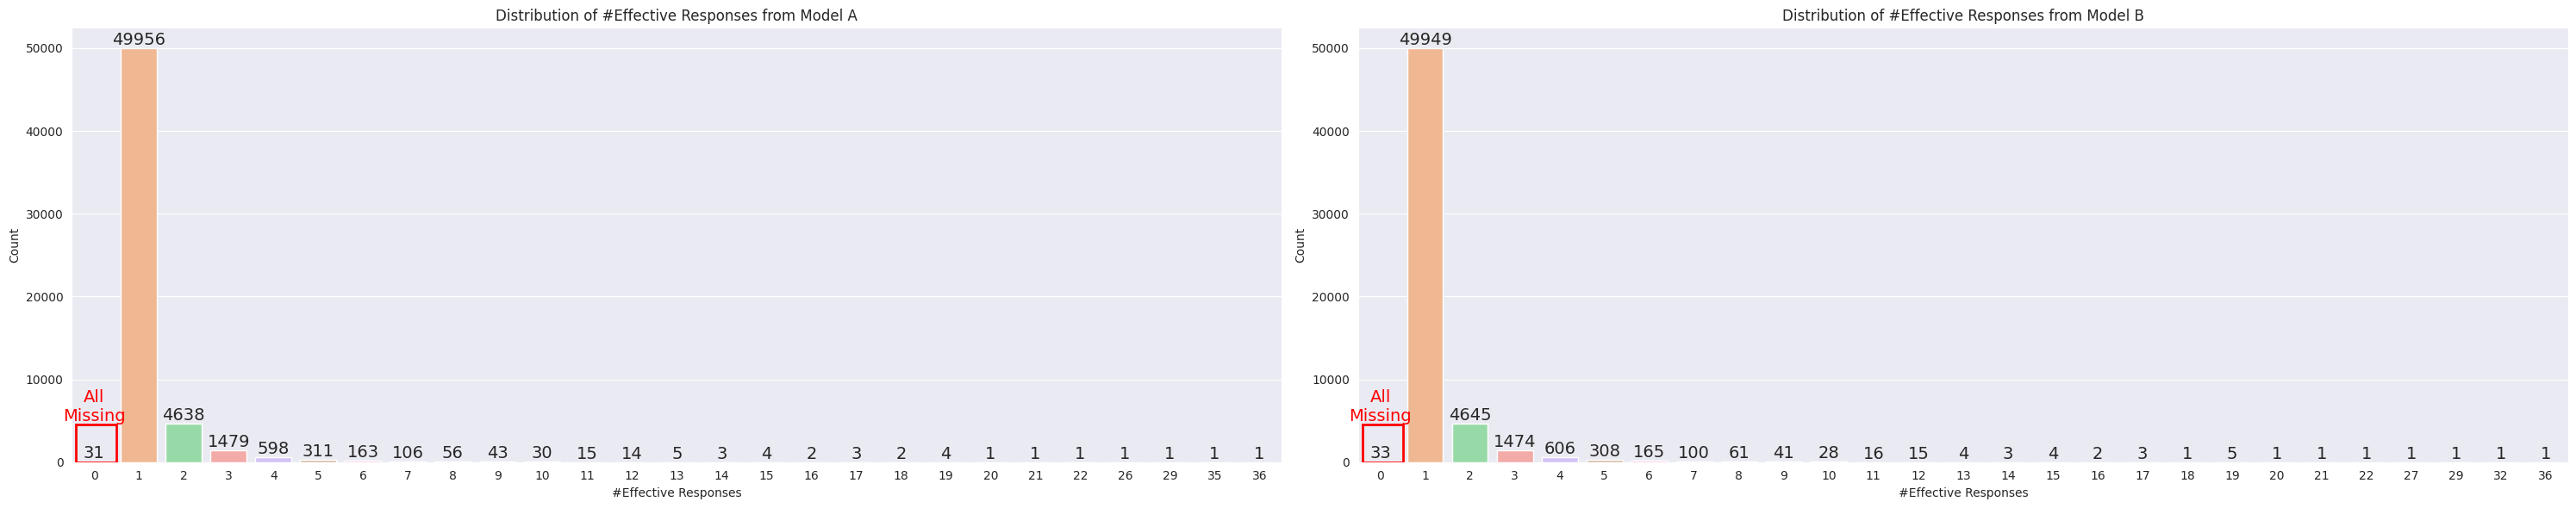

In [60]:
n_res_a_val_cnt = train["n_eff_res_a"].value_counts().sort_index()
data_a, labels_a = n_res_a_val_cnt.values, n_res_a_val_cnt.index.tolist()
n_res_b_val_cnt = train["n_eff_res_b"].value_counts().sort_index()
data_b, labels_b = n_res_b_val_cnt.values, n_res_b_val_cnt.index.tolist()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 6))
sns.barplot(x=labels_a, y=data_a, palette=colors, ax=axes[0])
axes[0].set_title(f"Distribution of #Effective Responses from Model A")
axes[0].set_xlabel("#Effective Responses")
axes[0].set_ylabel("Count")
for container in axes[0].containers:
    axes[0].bar_label(container, fontsize=14)
all_mis_a = patches.Rectangle((-0.4, 0), 0.9, 4500, linewidth=2, edgecolor="r", facecolor="none")
axes[0].add_patch(all_mis_a)
axes[0].text(0, 5000, "All\nMissing", c="r", fontsize=14, ha="center")

sns.barplot(x=labels_b, y=data_b, palette=colors, ax=axes[1])
axes[1].set_title(f"Distribution of #Effective Responses from Model B")
axes[1].set_xlabel("#Effective Responses")
axes[1].set_ylabel("Count")
for container in axes[1].containers:
    axes[1].bar_label(container, fontsize=14)
all_mis_b = patches.Rectangle((-0.4, 0), 0.9, 4500, linewidth=2, edgecolor="r", facecolor="none")
axes[1].add_patch(all_mis_b)
axes[1].text(0, 5000, "All\nMissing", c="r", fontsize=14, ha="center")
plt.tight_layout()

#### プロンプトの長さについて

次にプロンプトの長さがどのように影響するかを調べてみる。3種類の側面から考えてみる。①プロンプトの合計の長さ、②1回の会話の平均の長さ、③最大値。併せて、同じプロンプトが双方のLLMモデルに与えられていることからプロンプトの長さは勝敗には関係がないものとして扱っている。

1. 全ての分布について、右に長くなっている。極端に長いプロンプトでの会話は少ないことを表している。
2. 平均の分布は最大値の分布に似ており、87%の会話は1つのプロンプトのみで行われていることからと考えられる。
3. プロンプトの長さと勝敗については全くと言っていいほど相関はない。

In [61]:
def _add_len_stats(df: pd.DataFrame, col: str) -> pd.DataFrame:
    def _len(string: str) -> int:
        if string is None:
            return 0
        return len(string)
    
    if col == "prompt":
        col_prefix = "p_len"
    elif col == "response_a":
        col_prefix = "res_a_len"
    elif col == "response_b":
        col_prefix = "res_b_len"
        
    df[f"{col_prefix}_sum"] = df[col].apply(lambda x: sum(_len(s) for s in x))
    df[f"{col_prefix}_mean"] =  df[col].apply(lambda x: np.mean(list(_len(s) for s in x)))
    df[f"{col_prefix}_max"] = df[col].apply(lambda x: max(_len(s) for s in x))
    df[f"{col_prefix}_sum_log"] = np.log1p(df[f"{col_prefix}_sum"])
    df[f"{col_prefix}_mean_log"] =  np.log1p(df[f"{col_prefix}_mean"])
    df[f"{col_prefix}_max_log"] = np.log1p(df[f"{col_prefix}_max"])
    
    return df

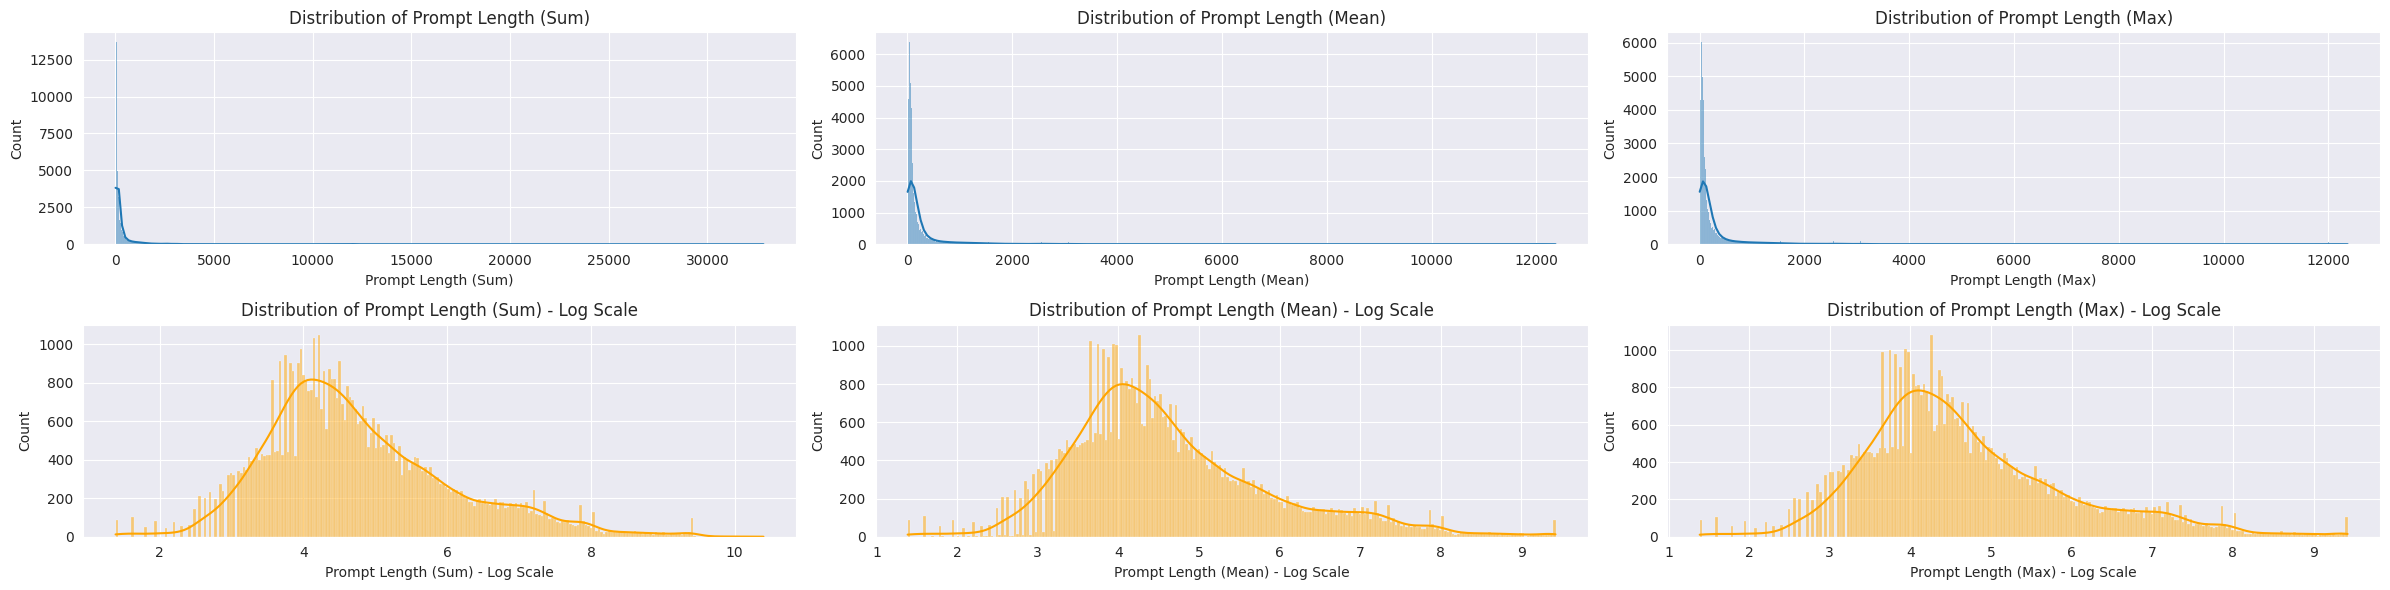

In [62]:
train = _add_len_stats(train, "prompt")

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 6))
for i, stats in enumerate(["sum", "mean", "max"]):
    # Original scale
    ax1 = axes[0][i]
    sns.histplot(train, x=f"p_len_{stats}", bins=1000, kde=True, ax=ax1)
    ax1.set_title(f"Distribution of Prompt Length ({stats.capitalize()})")
    ax1.set_xlabel(f"Prompt Length ({stats.capitalize()})")
    
    # Log scale
    ax2 = axes[1][i]
    sns.histplot(train, x=f"p_len_{stats}_log", bins=250, kde=True, color="orange", ax=ax2)
    ax2.set_title(f"Distribution of Prompt Length ({stats.capitalize()}) - Log Scale")
    ax2.set_xlabel(f"Prompt Length ({stats.capitalize()}) - Log Scale")
plt.tight_layout()

In [ ]:
corr = train[TARGETS + ["p_len_sum", "p_len_mean", "p_len_max"]].corr()

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(corr, cmap="crest", annot=True, ax=ax)
ax.set_title("Winner versus Prompt Length")
plt.show()

#### 回答の長さについて

LLMにも人間にも**冗長性バイアス**があること([斎藤らの研究](https://arxiv.org/pdf/2310.10076)はわかっているが、今回のデータセットにも影響しているのかどうかを調べてみる。

1. 上記と同様に長い文章での回答は少ないことを示している。
2. モデルAとBは平均値と最大の長さで異なっているように見える
    * 20,000字以上の長さの回答が存在することから、モデルBの回答に**外れ値**があると推定した。

In [ ]:
train = _add_len_stats(train, "response_a")
train = _add_len_stats(train, "response_b")

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(24, 12))
for i, stats in enumerate(["sum", "mean", "max"]):
    # Model A - original
    ax1 = axes[0][i]
    sns.histplot(train, x=f"res_a_len_{stats}", bins=1000, kde=True, ax=ax1)
    ax1.set_title(f"Distribution of Res A Length ({stats.capitalize()})")
    ax1.set_xlabel(f"Res A Length ({stats.capitalize()})")
    
    # Model A - log 
    ax2 = axes[1][i]
    sns.histplot(train, x=f"res_a_len_{stats}_log", bins=250, kde=True, color="orange", ax=ax2)
    ax2.set_title(f"Distribution of Res A Length ({stats.capitalize()}) - Log Scale")
    ax2.set_xlabel(f"Res A Length ({stats.capitalize()}) - Log Scale")
    
    # Model B - original
    ax3 = axes[2][i]
    sns.histplot(train, x=f"res_b_len_{stats}", bins=1000, kde=True, ax=ax3)
    ax3.set_title(f"Distribution of Res B Length ({stats.capitalize()})")
    ax3.set_xlabel(f"Res B Length ({stats.capitalize()})")
    
    # Model B - log 
    ax4 = axes[3][i]
    sns.histplot(train, x=f"res_b_len_{stats}_log", bins=250, kde=True, color="orange", ax=ax4)
    ax4.set_title(f"Distribution of Res B Length ({stats.capitalize()}) - Log Scale")
    ax4.set_xlabel(f"Res B Length ({stats.capitalize()}) - Log Scale")
plt.tight_layout()

モデルAとモデルBを同時にプロットすることで、平均と最大の長さにテールがある以外は、両者の分布がよく似ていることが観察できる。

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 4))
for i, stats in enumerate(["sum", "mean", "max"]):
    tmp_a = (
        train
        .loc[:, [f"res_a_len_{stats}"]]
        .rename({f"res_a_len_{stats}": f"res_len_{stats}"}, axis=1)
        .assign(model=["Model A"] * len(train))
    )
    tmp_b = (
        train
        .loc[:, [f"res_b_len_{stats}"]]
        .rename({f"res_b_len_{stats}": f"res_len_{stats}"}, axis=1)
        .assign(model=["Model B"] * len(train))
    )
    tmp = pd.concat([tmp_a, tmp_b], ignore_index=True)
    
    ax = axes[i]
    sns.kdeplot(tmp, x=f"res_len_{stats}", hue="model", palette=colors, linewidth=2, ax=ax)
    ax.set_title(f"Distribution of Res Length ({stats.capitalize()}) - A versus B")
    ax.set_xlabel("Response Length")
plt.tight_layout()

#### プロンプトと回答を組み合わせた際の長さ

以下の3パターンのアプローチから、**プロンプトと回答の合計の長さ**という尺度を持ってデータを見てみる。

1. モデルAとモデルBの回答の長さ
2. プロンプトの長さとモデルAの回答の長さ
3. プロンプトの長さとモデルBの回答の長さ

2つのモデルが生成した回答の長さは**強い正の相関がある**と結論付けられる。これは、どちらのモデルも同じプロンプトに対応しいることから結論付けられると考えられる。プロンプトの長さと回答の長さにはあまり強い相関は見られない。

In [ ]:
class _SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [ ]:
text_cfg = {
    "ha": "left",
    "va": "bottom",
    "bbox": {
        "boxstyle": "round",
        "pad": 0.25, 
        "facecolor": "white", 
        "edgecolor": "gray"
    }
}
r1, _ = scipy.stats.pearsonr(train["res_a_len_sum"], train["res_b_len_sum"])
r2, _ = scipy.stats.pearsonr(train["p_len_sum"], train["res_a_len_sum"])
r3, _ = scipy.stats.pearsonr(train["p_len_sum"], train["res_b_len_sum"])

fig = plt.figure(figsize=(24, 8))
gs = GridSpec(1, 3)
g0 = sns.jointplot(train, x="res_a_len_sum", y="res_b_len_sum", kind="reg")
g0.ax_joint.text(x=40000, y=51000, s=f"pearsonr = {r1:.3f}", **text_cfg)
g1 = sns.jointplot(train, x="p_len_sum", y="res_a_len_sum", color="g", kind="reg")
g1.ax_joint.text(x=25000, y=51000, s=f"pearsonr = {r2:.3f}", **text_cfg)
g2 = sns.jointplot(train, x="p_len_sum", y="res_b_len_sum", color="orange", kind="reg")
g2.ax_joint.text(x=25000, y=51000, s=f"pearsonr = {r3:.3f}", **text_cfg)
_SeabornFig2Grid(g0, fig, gs[0])
_SeabornFig2Grid(g1, fig, gs[1])
_SeabornFig2Grid(g2, fig, gs[2])
gs.tight_layout(fig)
plt.show()

#### 結論：冗長性バイアス

最後に、回答の長さが審判に与える影響に注目する。このデータセットに**冗長性バイアス**が存在するかどうかをチェックしてることにする。このセクションでは、説明のために1つの会話の平均の回答の長さを使用する。<br>

どのモデルが平均してより長い応答を出力するかを定量化するために、まずモデルAとモデルBの長さの差をとります。長さの差を切り取ると、分布は**左右対称**になります。<br>

[@robikscube](https://www.kaggle.com/robikscube)
[研究内容](https://www.kaggle.com/code/robikscube/lmsys-chatbot-arena-data-anaylsis#Response-Length-Baseline)
から、回答の長さの差のバケットと勝者の分布を共有する。また、より細かいバケットを作成した場合、バケット`(-1, 0]`の中で同点の確率が0.7以上になる。したがって、このデータセットには**冗長性バイアス**が存在すると結論づけられる。

In [ ]:
train["res_len_mean_diff"] = train["res_a_len_mean"] - train["res_b_len_mean"]
train["res_len_mean_diff_clip"] = train["res_len_mean_diff"].clip(-6000, 6000)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
sns.histplot(train, x="res_len_mean_diff", kde=True, ax=axes[0])
axes[0].set_title("Distribution of Difference of Mean Res Length")
axes[0].set_xlabel("Difference of Mean Res Length")
sns.histplot(train, x="res_len_mean_diff_clip", kde=True, ax=axes[1])
axes[1].set_title("Distribution of Difference of Mean Res Length [-6000, 6000]")
axes[1].set_xlabel("Difference of MeanRes Length")
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 6))

for i, n_quantiles in enumerate([100, 250]):
    train[f"len_diff_bucket_{n_quantiles}"] = pd.qcut(train["res_len_mean_diff"], n_quantiles)
    bucket_win_rates = train.groupby(f"len_diff_bucket_{n_quantiles}")[TARGETS].mean()
    lbs = [str(s) for idx, s in enumerate(bucket_win_rates.index) if idx % int(n_quantiles / 5) == 0]

    ax = axes[i]
    for j, col in enumerate(TARGETS):
        ax.plot(
            bucket_win_rates[col].values,
            c=colors[j],
            label=col.replace("_", " ").title(),
            linewidth=2,
        )
    mid_pt = n_quantiles // 2
    ax.axvline(mid_pt, c="r", linestyle="--", alpha=0.5)
    ax.text(x=mid_pt, y=0.65, s="Res B is longer ←", c="r", ha="right", fontsize=12)
    ax.text(x=mid_pt, y=0.675, s="→ Res A is longer", c="r", ha="left", fontsize=12)
    ax.set_title(f"Length Difference versus Winner Distribution - #Buckets {n_quantiles}")
    ax.set_xlabel("Length Difference Bucket")
    ax.set_ylabel("Winner Distribution")
    ax.set_xticks(np.arange(0, len(bucket_win_rates), int(n_quantiles / len(lbs))), labels=lbs)
    ax.legend()
plt.tight_layout()

#### 特定のLLMによる生成された回答の長さ
テストデータでは対応するLLMのモデル名が公表されていない為、どのモデルが長い回答を生成するのかわからない。ここに着目し、どのLLMモデルがより長い文章を生成するのかを見てみたい。<br>

LLMの平均的な回答の長さを以下に示す。併せて、モデルの出現率は緑の三角形で示してある。このことからわかった内容は下記である。
1. 4つのLLMモデルでは、回答は平均して1,500語よりも長い。
2. `gpt-4-0125-preview`と`gpt-4-1106-preview`は平均して**最も回答が長かった**LLMモデルである。
3. `alpaca-13b`と`llama-13b`は平均して最も**回答が短かった**LLMモデルである。

In [ ]:
llm_res_len_a = (
    train[["model_a", "res_a_len_mean", "winner_model_a"]]
    .rename({
        "model_a": "model", 
        "res_a_len_mean": "res_len_mean",
        "winner_model_a": "win"
    }, axis=1)
)
llm_res_len_b = (
    train[["model_b", "res_b_len_mean", "winner_model_b"]]
    .rename({
        "model_b": "model", 
        "res_b_len_mean": "res_len_mean",
        "winner_model_b": "win"
    }, axis=1)
)
llm_res_len = pd.concat([llm_res_len_a, llm_res_len_b], ignore_index=True)
tmp = (
    llm_res_len
    .groupby("model")
    .agg({
        "res_len_mean": ["mean"],
        "model": ["count"],
        "win": ["mean"]
    })
    .droplevel(1, axis=1)
    .rename({"model": "support"}, axis=1)
)

fig, ax = plt.subplots(figsize=(24, 6))
sns.barplot(
    x=tmp.index, 
    y=tmp["res_len_mean"], 
    palette=[sns.color_palette("rocket_r", as_cmap=True)(v) for v in np.linspace(0.1, 0.6, 64)],
    ax=ax
)
ax.axhline(1500, c="r", linestyle="--", linewidth=1.5)
ax.set_title("LLM Mean Response Length and Support")
ax.set_xlabel("Model")
ax.set_ylabel("Average Response Length")
ax.tick_params(axis="x", rotation=90)

ax2 = ax.twinx()
ax2.scatter(np.arange(64), tmp["support"], c="g", marker="^")
ax2.set_ylabel("Support △")
ax2.grid(False)
fig.show()

さらに、回答の長さと勝率を見てみる。正の相関があることがわかる。

In [ ]:
r, _ = scipy.stats.pearsonr(tmp["res_len_mean"], tmp["win"])

fig, ax = plt.subplots(figsize=(6, 5))
sns.regplot(
    data=tmp, x="res_len_mean", y="win",
    marker="x", color="black", line_kws=dict(color="r"), ax=ax
)
ax.text(x=0, y=0.58, s=f"pearsonr = {r:.3f}", **text_cfg)
ax.set_title("Mean Response Length versus Win Rate")
ax.set_xlabel("Mean Response Length")
ax.set_ylabel("Win Rate")
plt.tight_layout()

<a id="naive"></a>
## 3. 勝敗基準ラインの確認
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻る</span>**](#toc)

このセクションでは、評価方法について理解するために基準となるライン（ベースライン）を設けて、ベースラインがどのように機能するのか確認してみる。

|  Baseline   | CV  |  LB |
|  ----  | ----  | ----  |
| All 1/3  | 1.0986 | 1.098  |
| Mean Prediction  | 1.0972 | 1.098  |
| LLM-Specific Mean Prediction  | 1.1000 | X |
| Length Difference Bucket Mean Prediction  | 1.0511 | ? |

<a id="1_3"></a>
### *全てが1/3と仮定*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻る</span>**](#toc)

それぞれの結果が1/3ずつになると仮定して予測 `[winner_model_a, winner_model_b, winner_tie] = [1/3, 1/3, 1/3]`。

In [ ]:
y_true = train[TARGETS]
y_pred = np.full(y_true.shape, fill_value=1/3)
print(f">>> All 1/3 <<<")
print(f"Prediction global mean | {np.mean(y_pred, axis=0)}")
print(f"Log loss | {log_loss(y_true, y_pred):.4f}")

<a id="mean"></a>
### *全体の平均値と一致すると仮定*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻る</span>**](#toc)

モデルAの勝利：モデルBの勝利：引き分けの確率が全体の平均値と同じになると予測。

In [ ]:
y_pred = train[TARGETS].mean().values.reshape((1, -1))
y_pred = np.repeat(y_pred, len(y_true), axis=0)

print(f">>> Mean Prediction <<<")
print(f"Prediction global mean | {np.mean(y_pred, axis=0)}")
print(f"Log loss | {log_loss(y_true, y_pred):.4f}")

<a id="llm_mean"></a>
### *LLM毎に平均を取って勝率を予測*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻る</span>**](#toc)

このベースラインでは、各LLMの平均値を予測として利用する。2つのLLMモデルの確立（勝率など）の合計が1以上ならば、その勝率を1/3と仮定して埋める。

In [ ]:
y_pred = train[["model_a", "model_b"] + TARGETS]
winner_a_mean = train[["model_a", "winner_model_a"]].groupby("model_a").mean().squeeze()
winner_b_mean = train[["model_b", "winner_model_b"]].groupby("model_b").mean().squeeze()
y_pred["winner_model_a"] = y_pred["model_a"].map(winner_a_mean)
y_pred["winner_model_b"] = y_pred["model_b"].map(winner_b_mean)
y_pred["winner_tie"] = 1 - (y_pred["winner_model_a"] + y_pred["winner_model_b"])
tie_mask = y_pred["winner_tie"] < 0
y_pred.loc[tie_mask, TARGETS] = 1 / 3

print(f">>> Mean Prediction <<<")
print(f"Prediction global mean | {np.mean(y_pred[TARGETS].values, axis=0)}")
print(f"Log loss | {log_loss(y_true, y_pred[TARGETS]):.4f}")

<a id="len_diff"></a>
### *バケットごとの平均値で推論*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻る</span>**](#toc)

回答の長さをバケットごとに分けて分析、各バケットの長さ毎に分けて推測している。また、同時に異なる粒度での長さをバケットとして使用している。
文量が増えればLoglossは低減。

In [ ]:
def _get_len_diff_bucket_pred(n_quantiles: int) -> pd.DataFrame:
    y_pred = train[["res_len_mean_diff"] + TARGETS]
    y_pred[f"len_diff_bucket_{n_quantiles}"] = pd.qcut(train["res_len_mean_diff"], n_quantiles)
    bucket_win_rates = y_pred.groupby(f"len_diff_bucket_{n_quantiles}")[TARGETS].mean()
    for col in TARGETS:
        y_pred[col] = y_pred[f"len_diff_bucket_{n_quantiles}"].map(bucket_win_rates[col])
        
    return y_pred

In [ ]:
prfs = {}
for n_quantiles in [25, 50, 100, 150, 200, 250]:
    y_pred = _get_len_diff_bucket_pred(n_quantiles)
    prfs[n_quantiles] = log_loss(y_true, y_pred[TARGETS])

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(list(prfs.values()), "ro-")
ax.set_title("Performance of Length Difference Bucket Mean Prediction")
ax.set_xlabel("#Quantiles")
ax.set_ylabel("Log Loss")
ax.set_xticks(np.arange(6), labels=list(prfs.keys()))
plt.show()

<a id="ml"></a>
## 4. 機械学習を用いたベースライン
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻る</span>**](#toc)

このセクションでは、上記のようなベースラインのほかに、伝統的な機械学習を用いて上記ベースラインよりも優れた予測が行えるのか試してみる。

<a id="fe"></a>
### *特徴量エンジニアリング*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻る</span>**](#toc)

最初にEDAで得られた知見をもとに特徴量を作成してみる。

In [ ]:
def _len(string: str) -> int:
    """Return the length of the string."""
    if string is None:
        return 0
    return len(string)

In [ ]:
# Missing prompt ratio 「プロンプトの欠損率」
train["n_miss_prompts"] = train["n_na_prompts"] + train["n_empty_prompts"]
train["n_eff_prompts"] = train["n_prompts"] - train["n_miss_prompts"]

train["na_prompt_ratio"] = train["n_na_prompts"] / train["n_prompts"]
train["empty_prompt_ratio"] = train["n_empty_prompts"] / train["n_prompts"]
train["miss_prompt_ratio"] = train["n_miss_prompts"] / train["n_prompts"]

# Missing response ratio 「回答の欠損率」
train["na_res_a_ratio"] = train["n_na_res_a"] / train["n_res_a"]
train["empty_res_a_ratio"] = train["n_empty_res_a"] / train["n_res_a"]
train["miss_res_a_ratio"] = train["n_miss_res_a"] / train["n_res_a"]
train["na_res_b_ratio"] = train["n_na_res_b"] / train["n_res_b"]
train["empty_res_b_ratio"] = train["n_empty_res_b"] / train["n_res_b"]
train["miss_res_b_ratio"] = train["n_miss_res_b"] / train["n_res_b"]

# Length features 「長さの特徴量」
for col, col_prefix in zip(["prompt", "response_a", "response_b"], ["p_len", "res_a_len", "res_b_len"]):
    train[f"{col_prefix}_med"] = train[col].apply(lambda x: np.median(list(_len(s) for s in x)))
    train[f"{col_prefix}_std"] = train[col].apply(lambda x: np.std(list(_len(s) for s in x)))
train["p_len_eff_mean"] = train["p_len_sum"] / train["n_eff_prompts"]
train["res_a_len_eff_mean"] = train["res_a_len_sum"] / train["n_eff_res_a"]
train["res_b_len_eff_mean"] = train["res_b_len_sum"] / train["n_eff_res_b"]

for stats in ["sum", "mean", "max", "med", "eff_mean"]:
    train[f"p_a_{stats}_diff"] = train[f"p_len_{stats}"] - train[f"res_a_len_{stats}"]
    train[f"p_b_{stats}_diff"] = train[f"p_len_{stats}"] - train[f"res_b_len_{stats}"]
    train[f"a_b_{stats}_diff"] = train[f"res_a_len_{stats}"] - train[f"res_b_len_{stats}"]
    
train.head(2)

<a id="dt"></a>
### *特徴量が1つのみの決定木*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻る</span>**](#toc)

上記で得られた最も有用なベースラインは、各長さをバケットとして利用するものであった。その際のLogLossは1.0511であった。まずは決定木にて、特徴量1つ（モデルAとBの平均の差）を用いて予測を行ってみることにする。<br>
ここからわかることとして、結果は少しだけ悪いもののベースラインで得られた推論に近いものが得られた。

In [ ]:
def _run_cv(
    X: pd.DataFrame,
    y: pd.Series,
    cv: BaseCrossValidator,
    models: List[BaseEstimator],
) -> List[float]:
    """Run cross-validation.
    
    Args:
        X: The feature matrix.
        y: The ground truth.
        cv: The cross validator.
        models: The unfitted estimators.
    
    Returns:
        scores: OOF scores.
    """
    scores = []
    for fold, (tr_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"## Fold {fold} ##")
        
        # Split training and validation sets
        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        models[fold].fit(X_tr, y_tr)

        y_tr_pred = models[fold].predict_proba(X_tr)
        y_val_pred = models[fold].predict_proba(X_val)
        tr_score, val_score = log_loss(y_tr, y_tr_pred), log_loss(y_val, y_val_pred)
        print(f"Log loss | Train {tr_score:.4f} | Val {val_score:.4f}")
        scores.append(val_score)

    return scores

In [ ]:
# Prepare data
train["y"] = np.where(train[TARGETS])[1]
X, y = train[["a_b_eff_mean_diff"]].fillna(0), train["y"]

# Build cross validator
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Build models
model_cfg = {
    "criterion": "log_loss",
    "max_depth": 4,
    "min_samples_leaf": 1500,
    "random_state": 42,
}
models = [DecisionTreeClassifier(**model_cfg) for _  in range(4)]

# Run local cross validation
scores = _run_cv(X, y, skf, models)
print(f"\n>>> Performance Report <<<")
print(f"OOF log loss | {np.mean(scores):.4f} +- {np.std(scores):.4f}")

ベースラインと比較するために各決定木がどのように分解されていくのかを確認してみた。<br>


興味深いことに決定木が自発的に長さの差と勝率について学習している。下記の図では、左から順にwinner_model_a, winner_tie, winner_model_bの順で学習が進んでいる。

In [ ]:
for fold, model in enumerate(models):
    fig, ax = plt.subplots(figsize=(40, 10))
    plot_tree(model, class_names=["A", "B", "Tie"], filled=True, rounded=True, fontsize=12, ax=ax)
    ax.set_title(f"Decision Tree of Fold {fold}", fontsize=14)
    plt.tight_layout()

<a id="more_feat"></a>
### *より多くの特徴量*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">目次に戻る</span>**](#toc)

特徴量が1つでは学習不足を引き起こす可能性があるため、より多くの特徴量を決定木に組み込んでみる。<br>

In [ ]:
feats_to_skip = (
    ["model_a", "model_b", "prompt", "response_a", "response_b"]
    + ["n_res_a", "n_res_b"]
    + [c for c in train.columns if "log" in c]
    + ["res_len_mean_diff", "res_len_mean_diff_clip", "len_diff_bucket_100", "len_diff_bucket_250"]
    + TARGETS
    + ["y"]
)
feats = [col for col in train.columns if col not in feats_to_skip]
print(f"{len(feats)} features are selected!")

結果はほんのわずかだけの変化であり、基本的なベースラインよりも上回るスコアを出すことはなかった。併せて、回答の長さの差が重要な特徴量であることは少なくとも観察できる。

In [ ]:
X, y = train[feats].fillna(0), train["y"]
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
model_cfg = {
    "criterion": "log_loss",
    "max_depth": 6,
    "min_samples_leaf": 1500,
    "max_features": 0.7,
    "random_state": 42,
}
models = [DecisionTreeClassifier(**model_cfg) for _  in range(4)]

# Run local cross validation
scores = _run_cv(X, y, skf, models)
print(f"\n>>> Performance Report <<<")
print(f"OOF log loss | {np.mean(scores):.4f} +- {np.std(scores):.4f}")

In [ ]:
for fold, model in enumerate(models):
    fig, ax = plt.subplots(figsize=(40, 10))
    plot_tree(
        model, 
        feature_names=feats,
        class_names=["A", "B", "Tie"], 
        max_depth=4,
        filled=True, rounded=True, fontsize=12, ax=ax
    )
    ax.set_title(f"Decision Tree of Fold {fold}", fontsize=14)
    plt.tight_layout()